# Dependencies and files

## Imports

In [1]:
import scanpy as sc
import pandas as pd
import numpy as np
import gseapy
import os
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

# Global variables

## Load files

### Load pseudobulks

In [2]:
adata_pb = sc.read_h5ad('../data/snRNAseq_data/velmeshevvelm_pb_sum.h5ad')
adata_pb = adata_pb[(adata_pb.obs.diagnosis == "Control")]
adata_pb

View of AnnData object with n_obs × n_vars = 321 × 41202
    obs: 'cluster', 'sample', 'individual', 'region', 'age', 'sex', 'diagnosis', 'Capbatch', 'Seqbatch', 'post-mortem interval (hours)', 'RNA Integrity Number', 'psbulk_n_cells', 'psbulk_counts'
    var: 'gene_ids'
    layers: 'psbulk_props'

In [3]:
annot = sc.queries.biomart_annotations("hsapiens", ["ensembl_gene_id", "start_position", "end_position", "chromosome_name", "gene_biotype"])
adata_pb.var.columns = ['ensembl_gene_id']
new_var = adata_pb.var.reset_index().set_index('ensembl_gene_id').merge(annot.set_index('ensembl_gene_id'), left_index=True, right_index=True).reset_index().set_index('index')
adata_pb = adata_pb[:, new_var.index]
adata_pb.var = new_var
adata_pb

AnnData object with n_obs × n_vars = 321 × 39965
    obs: 'cluster', 'sample', 'individual', 'region', 'age', 'sex', 'diagnosis', 'Capbatch', 'Seqbatch', 'post-mortem interval (hours)', 'RNA Integrity Number', 'psbulk_n_cells', 'psbulk_counts'
    var: 'ensembl_gene_id', 'start_position', 'end_position', 'chromosome_name', 'gene_biotype'
    layers: 'psbulk_props'

In [4]:
adata_pb = adata_pb[:, adata_pb.var.gene_biotype == 'protein_coding']
adata_pb

View of AnnData object with n_obs × n_vars = 321 × 18233
    obs: 'cluster', 'sample', 'individual', 'region', 'age', 'sex', 'diagnosis', 'Capbatch', 'Seqbatch', 'post-mortem interval (hours)', 'RNA Integrity Number', 'psbulk_n_cells', 'psbulk_counts'
    var: 'ensembl_gene_id', 'start_position', 'end_position', 'chromosome_name', 'gene_biotype'
    layers: 'psbulk_props'

In [5]:
expression = pd.DataFrame(adata_pb.X, index=adata_pb.obs_names, columns=adata_pb.var_names)
expression.T.to_csv('results/celltype_expression.csv')
adata_pb.obs.to_csv('results/celltype_annotation.csv')

## Load snRNA-Seq

In [6]:
adata_velm = sc.read_h5ad('../data/snRNAseq_data/velmesh_raw_counts.h5ad')
adata_velm = adata_velm[(adata_velm.obs.diagnosis == "Control")]
adata_velm

View of AnnData object with n_obs × n_vars = 52556 × 65217
    obs: 'cluster', 'sample', 'individual', 'region', 'age', 'sex', 'diagnosis', 'Capbatch', 'Seqbatch', 'post-mortem interval (hours)', 'RNA Integrity Number', 'genes', 'UMIs', 'RNA mitochondr. percent', 'RNA ribosomal percent'
    var: 'gene_ids'

# Preprocess snRNA-Seq

In [7]:
sc.pp.normalize_total(adata_velm, target_sum=1e4)
sc.pp.log1p(adata_velm)

c:\projects\spatialMPFC\venv\Lib\site-packages\scanpy\preprocessing\_normalization.py:206: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


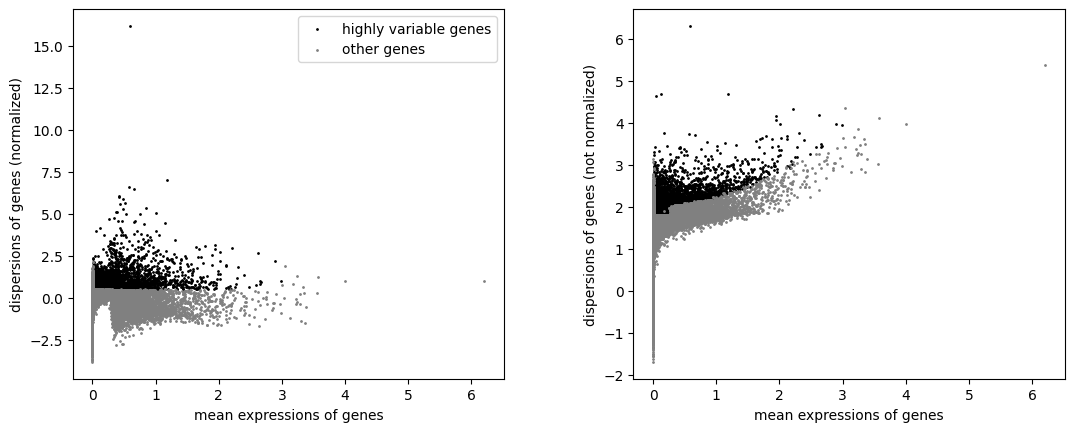

In [8]:
sc.pp.highly_variable_genes(adata_velm, batch_key='region')
sc.pl.highly_variable_genes(adata_velm)

In [9]:
sc.pp.neighbors(adata_velm)
sc.tl.pca(adata_velm)
sc.tl.umap(adata_velm)

         Falling back to preprocessing with `sc.pp.pca` and default params.


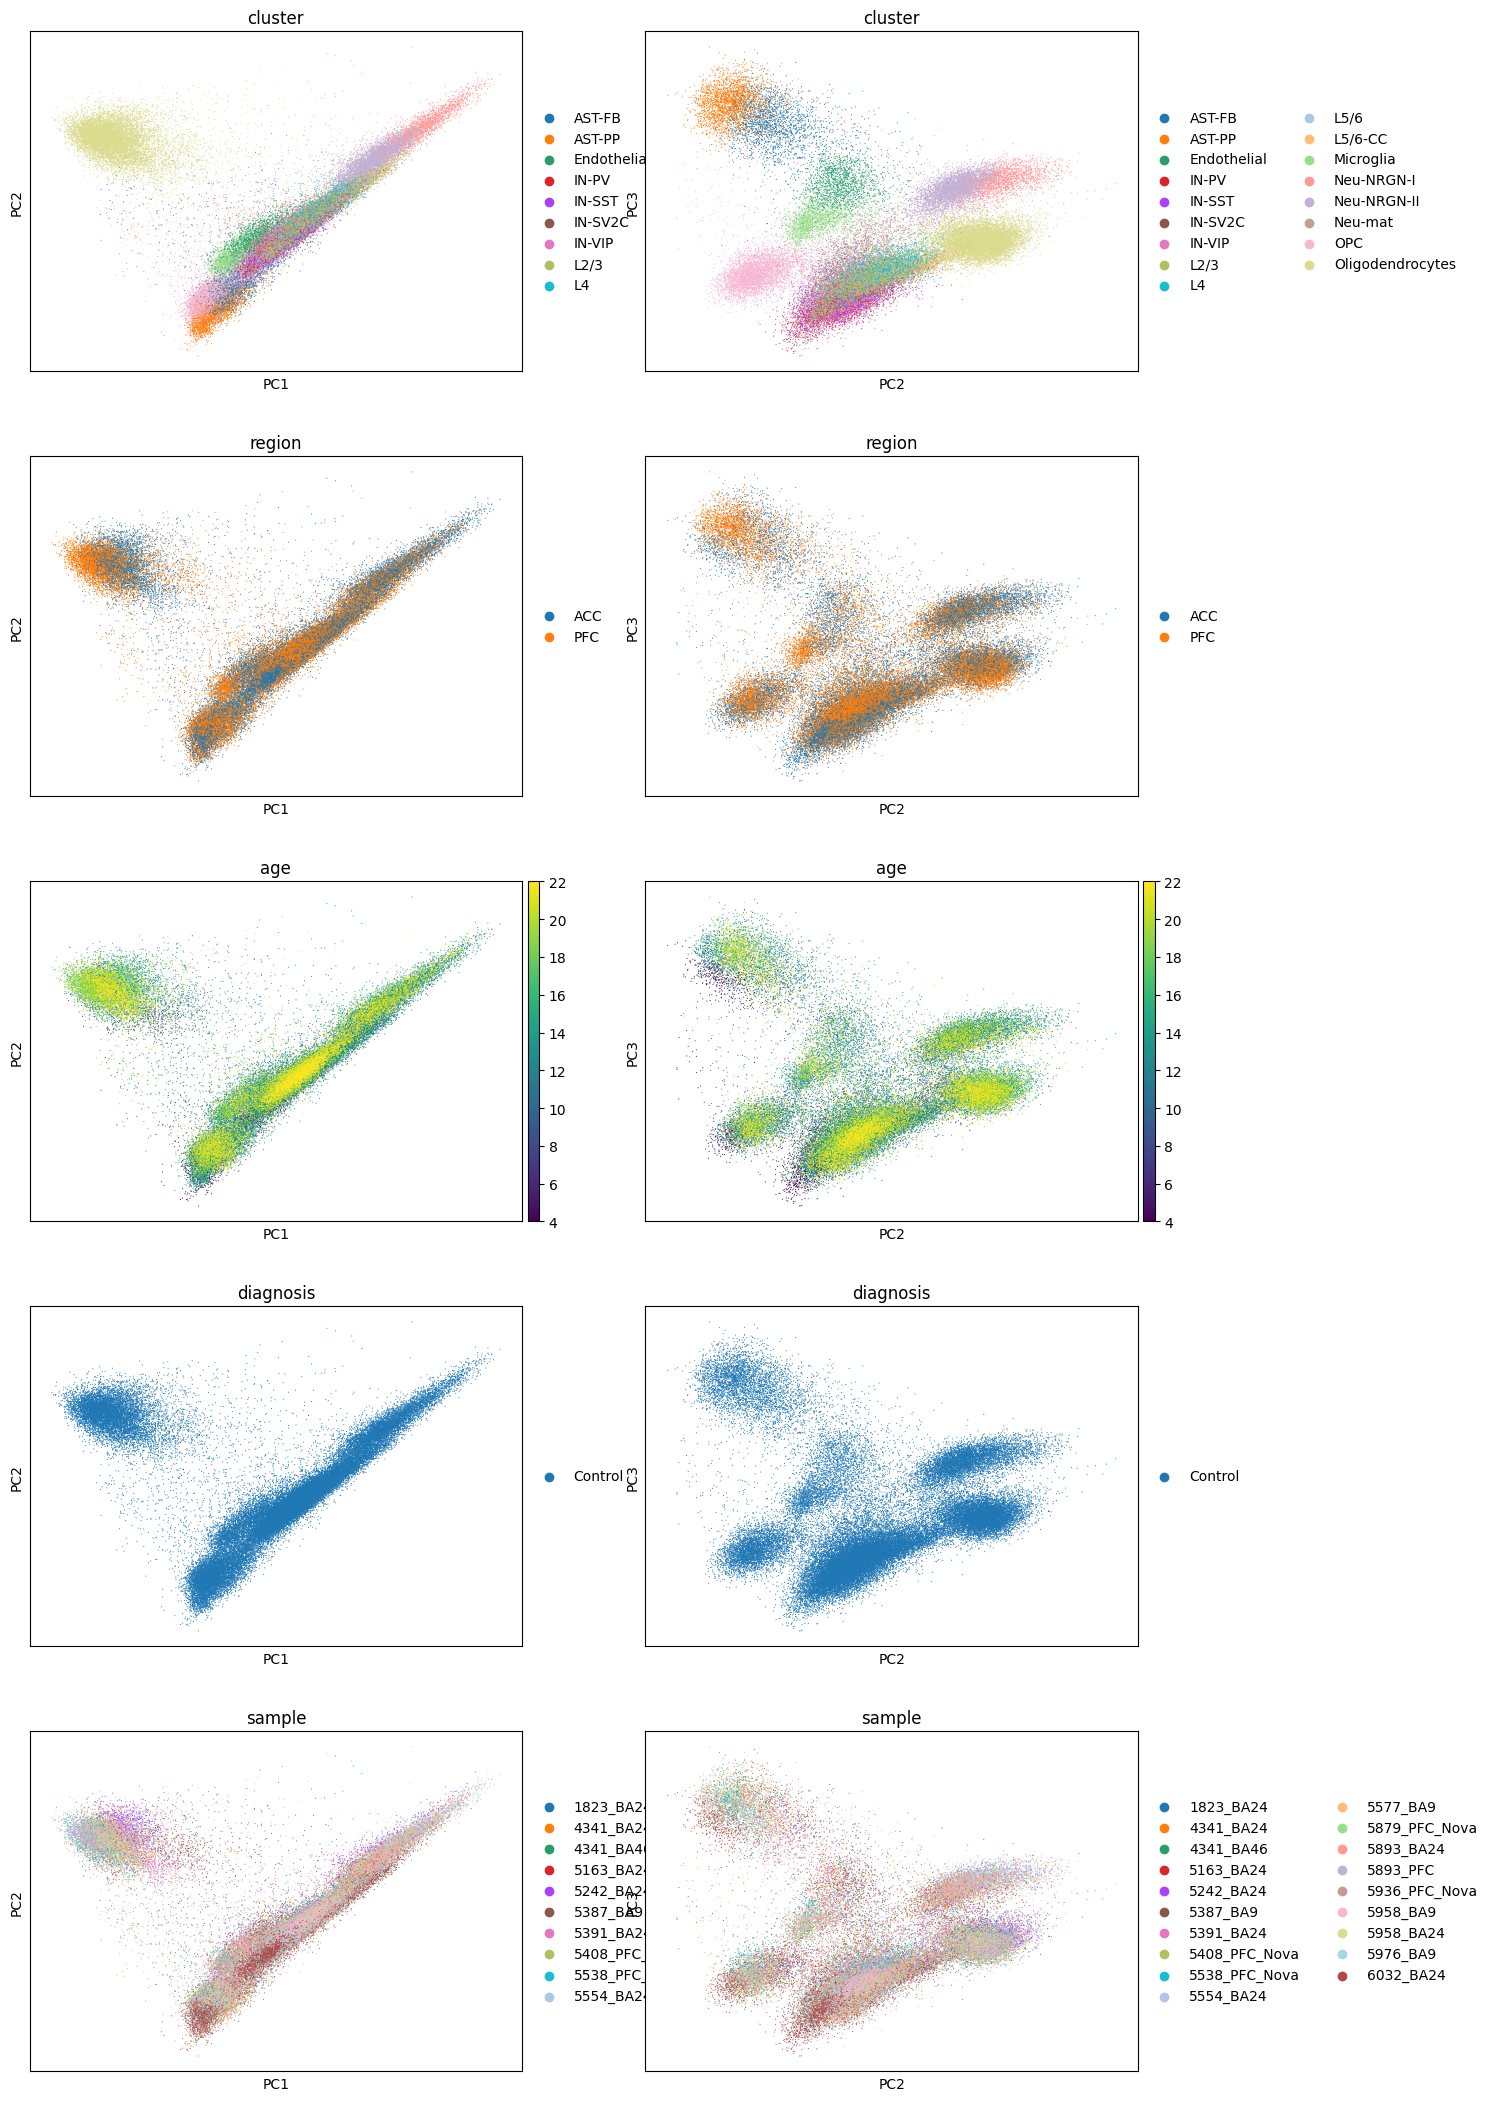

In [10]:
sc.pl.pca(adata_velm, color=['cluster', 'region', 'age', 'diagnosis', 'sample'], components=['1,2', '2,3'], ncols=2)

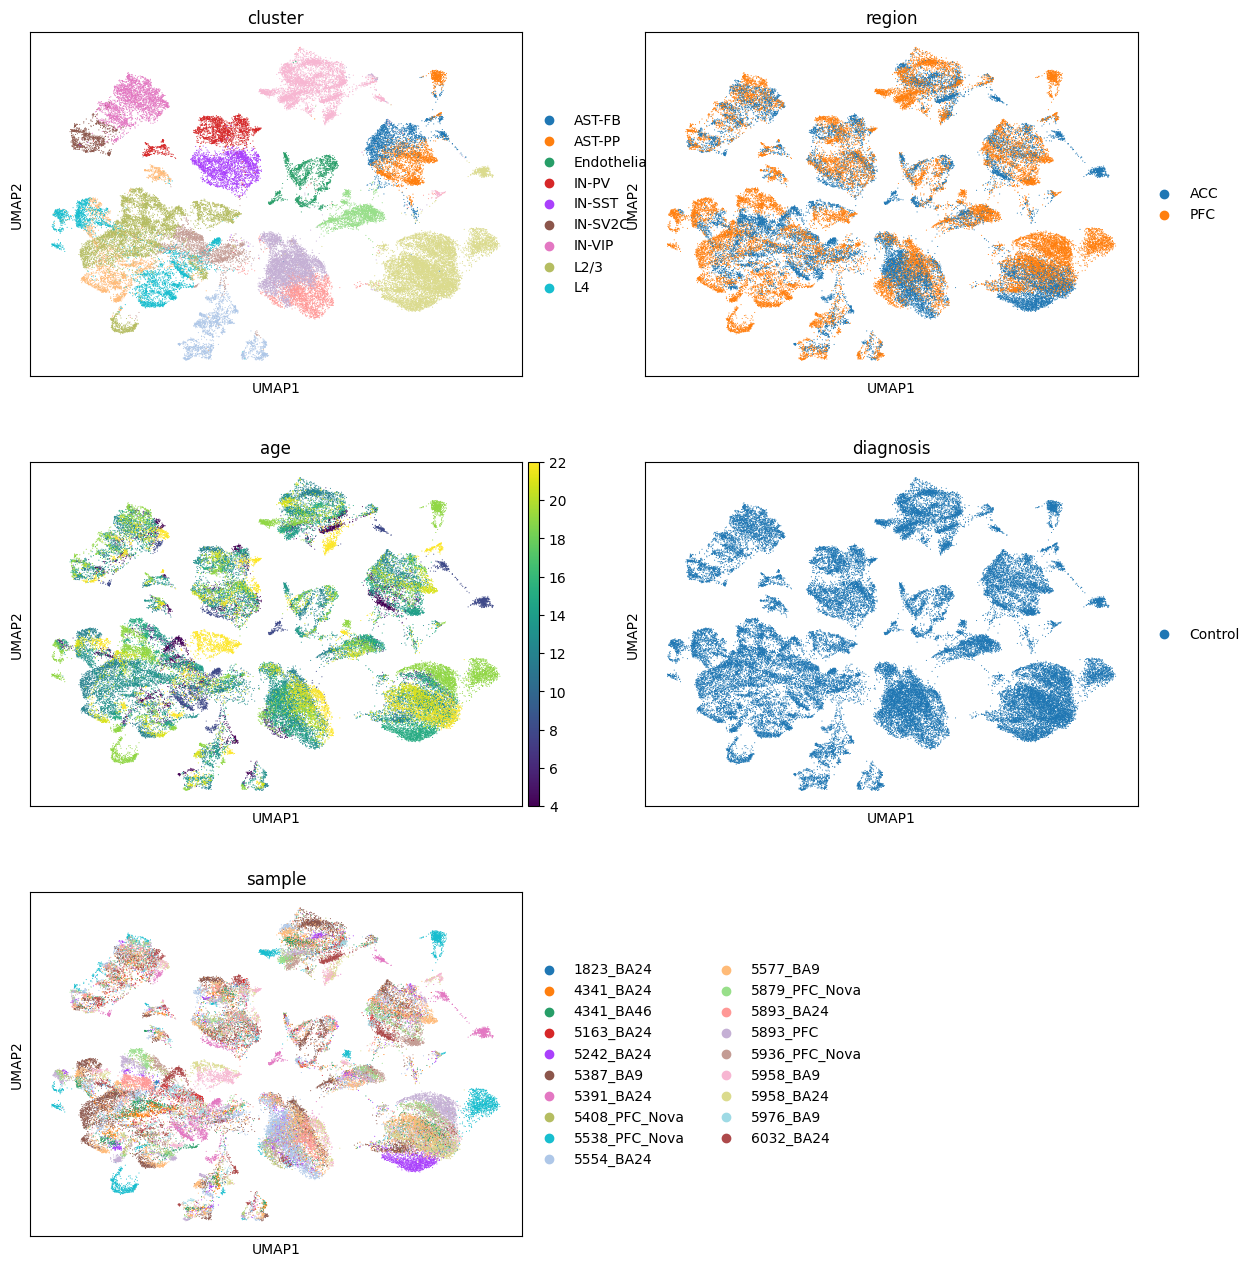

In [11]:
sc.pl.umap(adata_velm, color=['cluster', 'region', 'age', 'diagnosis', 'sample'], ncols=2)

In [12]:
adata_velm.write_h5ad("results/adata_velm_umap.h5ad")

# Preprocess

## Filter

In [13]:
sc.pp.filter_genes(adata_pb, min_counts=100)
sc.pp.filter_genes(adata_pb, min_cells=20)

c:\projects\spatialMPFC\venv\Lib\site-packages\scanpy\preprocessing\_simple.py:273: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var["n_counts"] = number


In [14]:
adata_pb

AnnData object with n_obs × n_vars = 321 × 16102
    obs: 'cluster', 'sample', 'individual', 'region', 'age', 'sex', 'diagnosis', 'Capbatch', 'Seqbatch', 'post-mortem interval (hours)', 'RNA Integrity Number', 'psbulk_n_cells', 'psbulk_counts'
    var: 'ensembl_gene_id', 'start_position', 'end_position', 'chromosome_name', 'gene_biotype', 'n_counts', 'n_cells'
    layers: 'psbulk_props'

## Normalize

In [15]:
sc.pp.normalize_total(adata_pb, target_sum=1e4)
sc.pp.log1p(adata_pb)

Highly variable genes: 3880


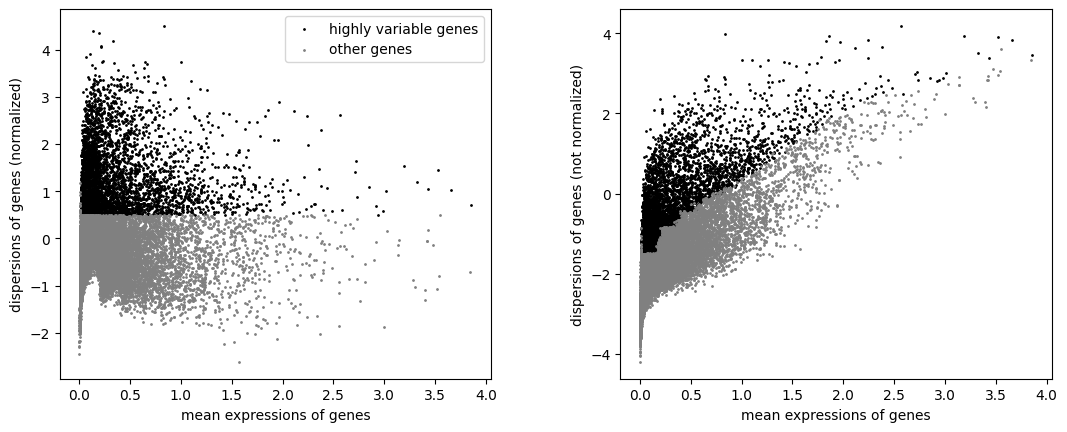

In [16]:
sc.pp.highly_variable_genes(adata_pb, batch_key='region', max_mean=5)
print("Highly variable genes: %d"%sum(adata_pb.var.highly_variable))

#plot variable genes
sc.pl.highly_variable_genes(adata_pb)

## Visualize

In [17]:
sc.tl.pca(adata_pb)

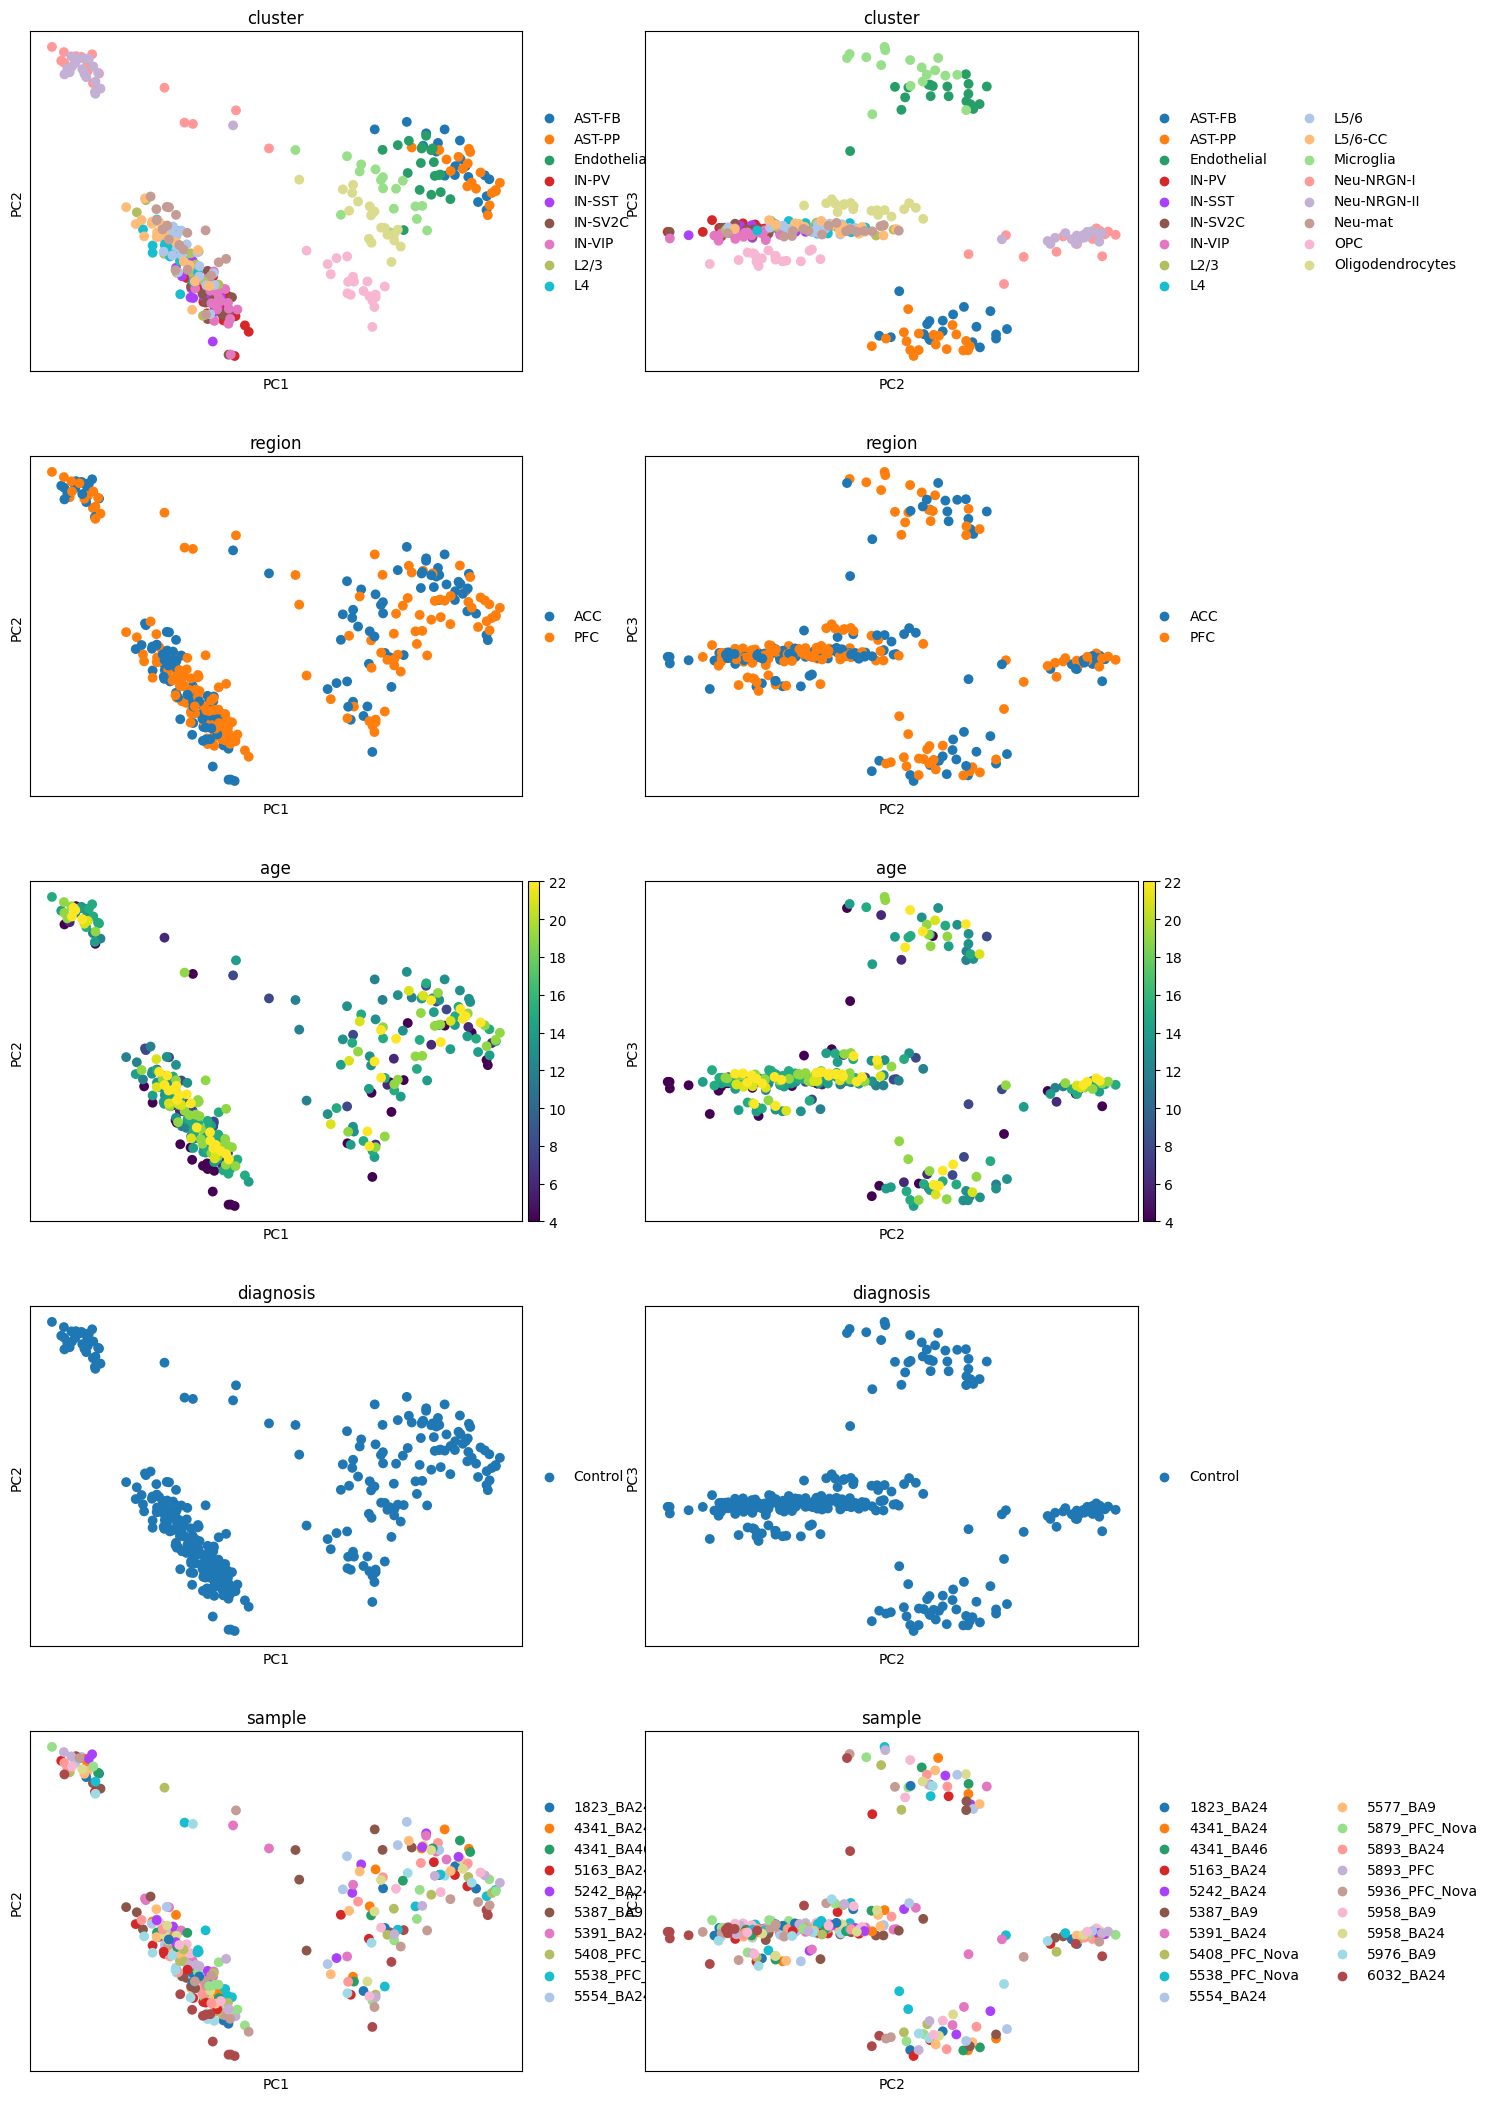

In [18]:
sc.pl.pca(adata_pb, color=['cluster', 'region', 'age', 'diagnosis', 'sample'], size=200, components=['1,2', '2,3'], ncols=2)

In [19]:
sc.pp.neighbors(adata_pb)
sc.tl.umap(adata_pb)

c:\projects\spatialMPFC\venv\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:301: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


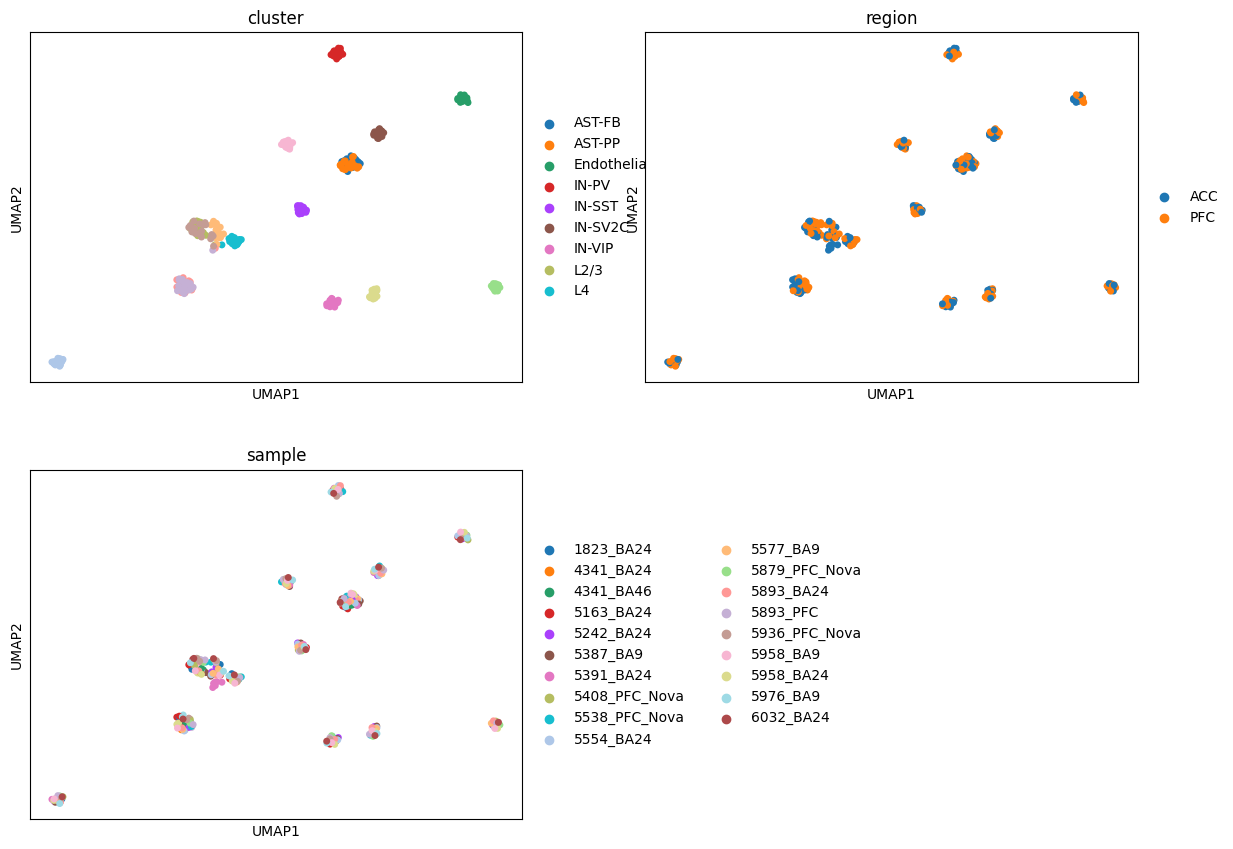

In [20]:
sc.pl.umap(adata_pb, color=['cluster', 'region', 'sample'], size=100, ncols=2)

# Rank genes

## T-test

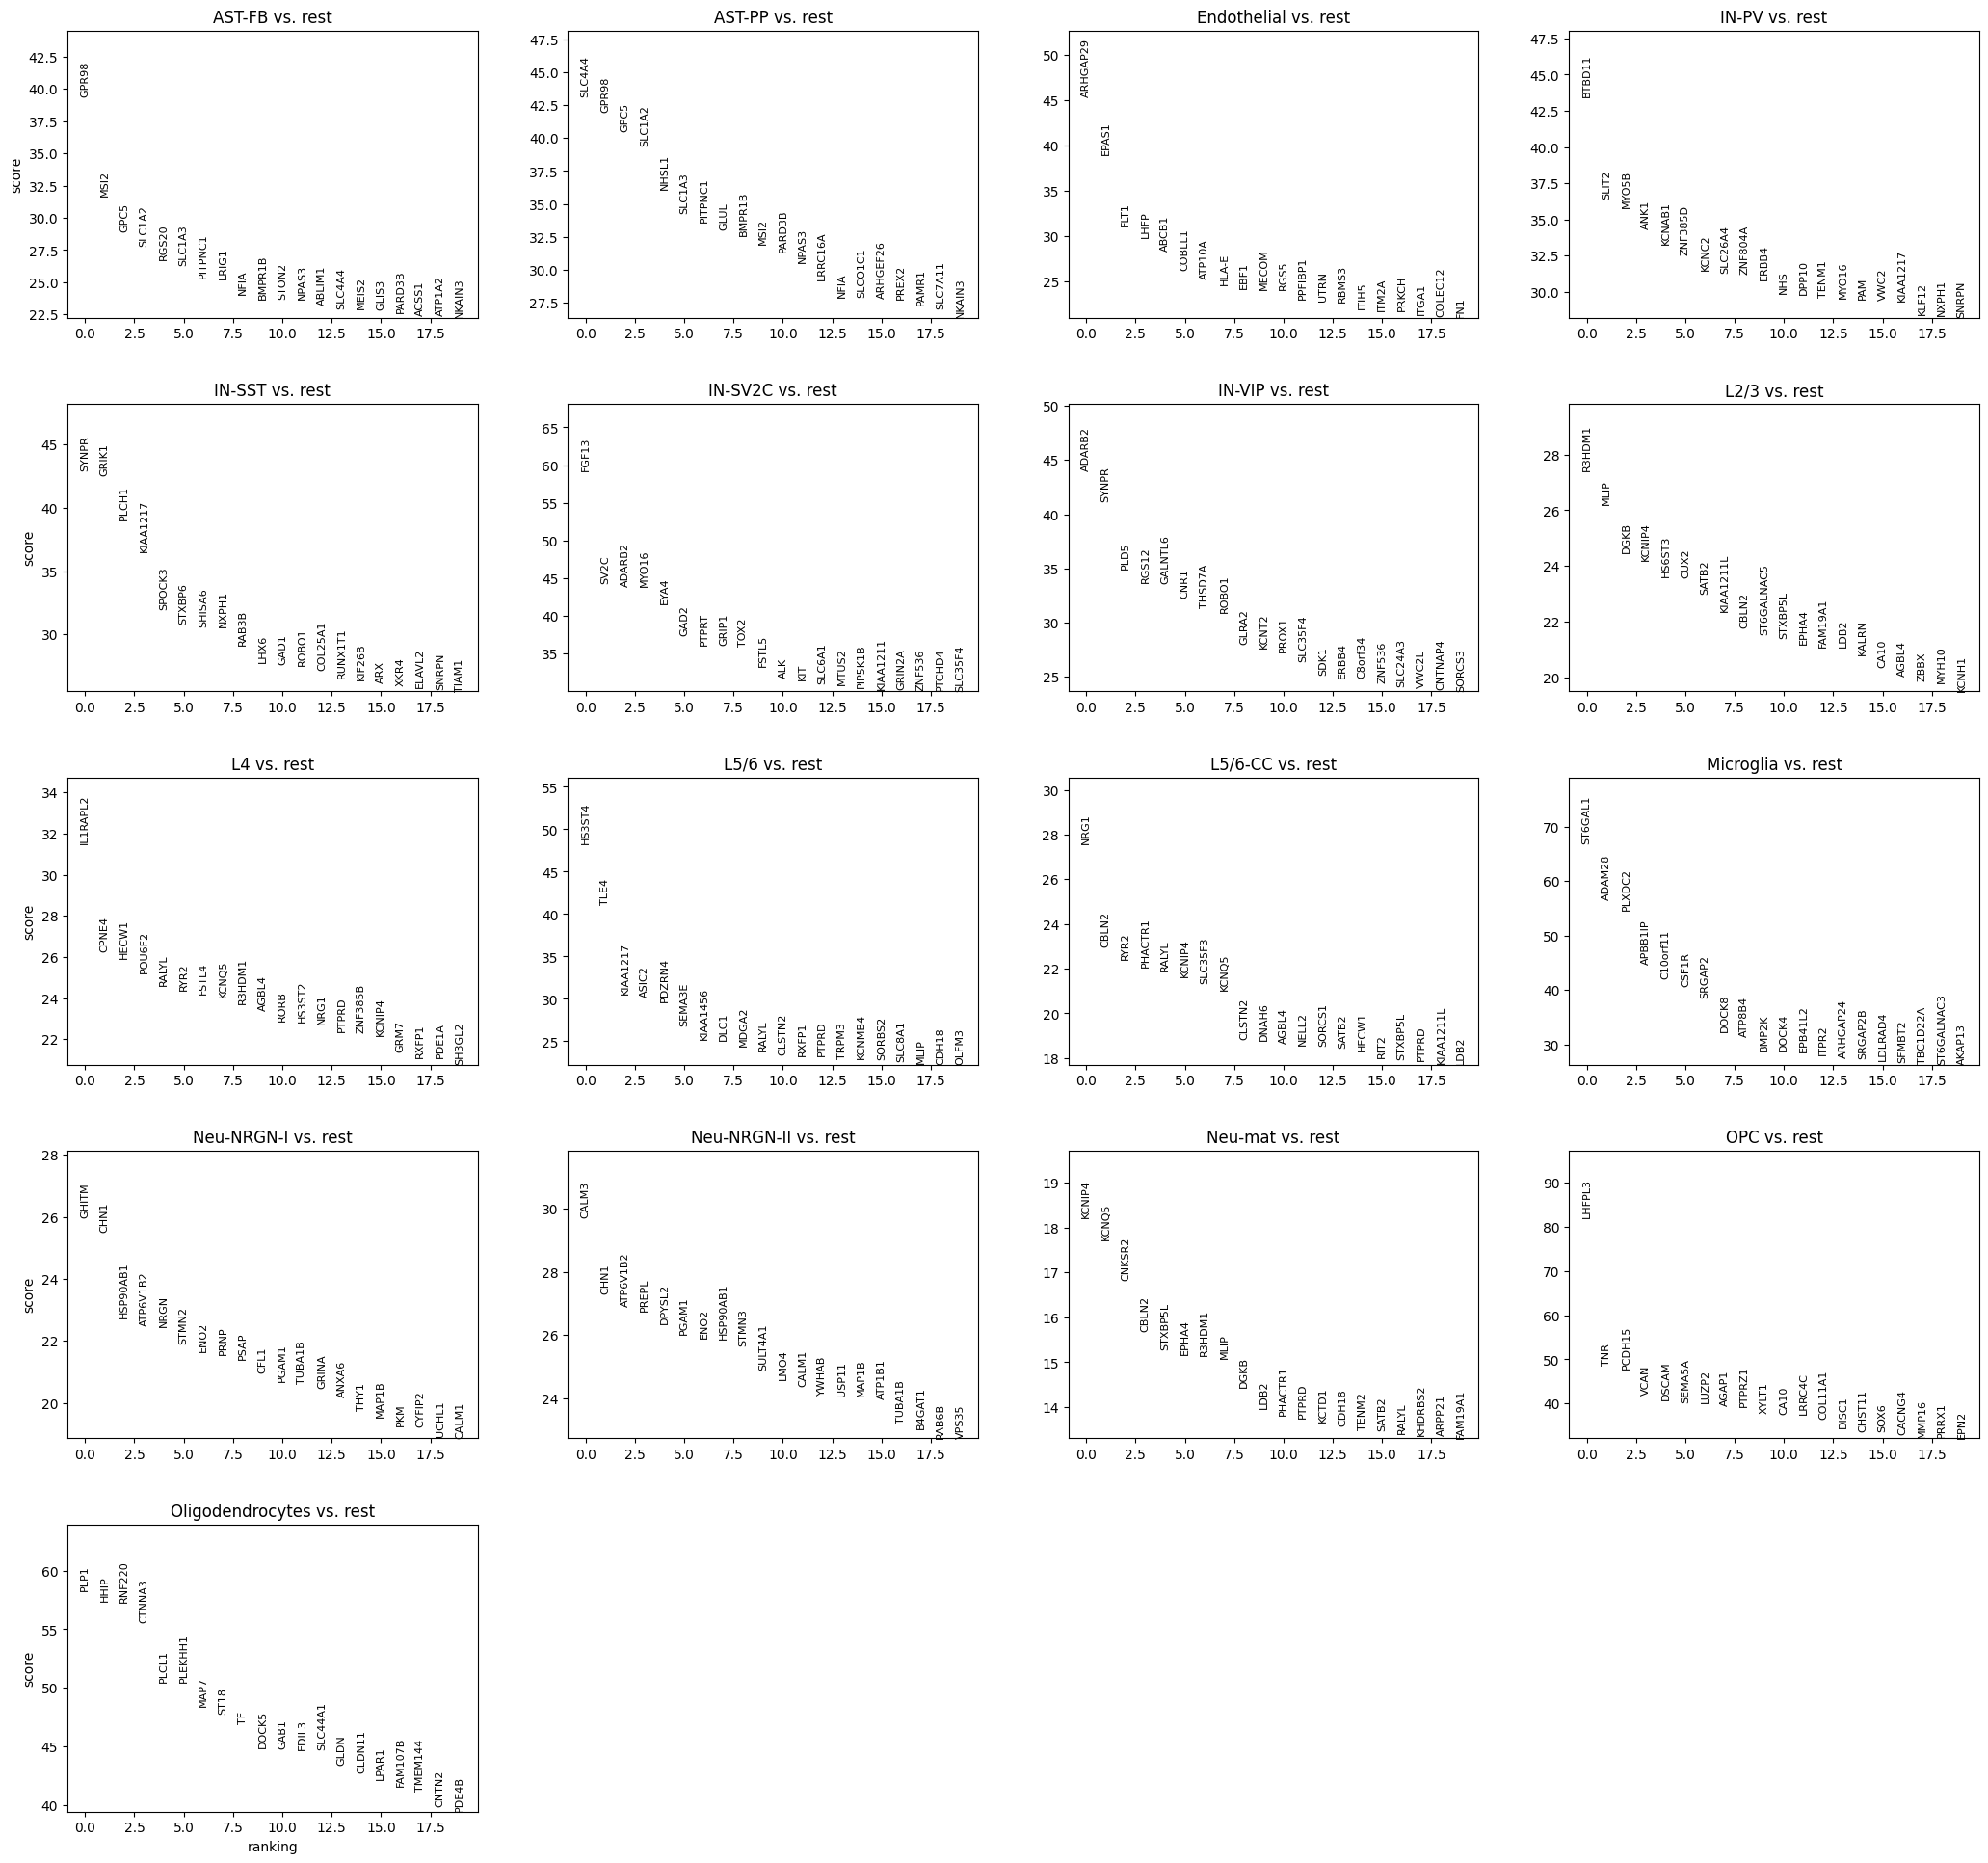

In [21]:
sc.tl.rank_genes_groups(adata_pb, 'cluster', method='t-test', reference='rest', key_added="t-test", pts=True)
sc.pl.rank_genes_groups(adata_pb, n_genes=20, sharey=False, key="t-test")

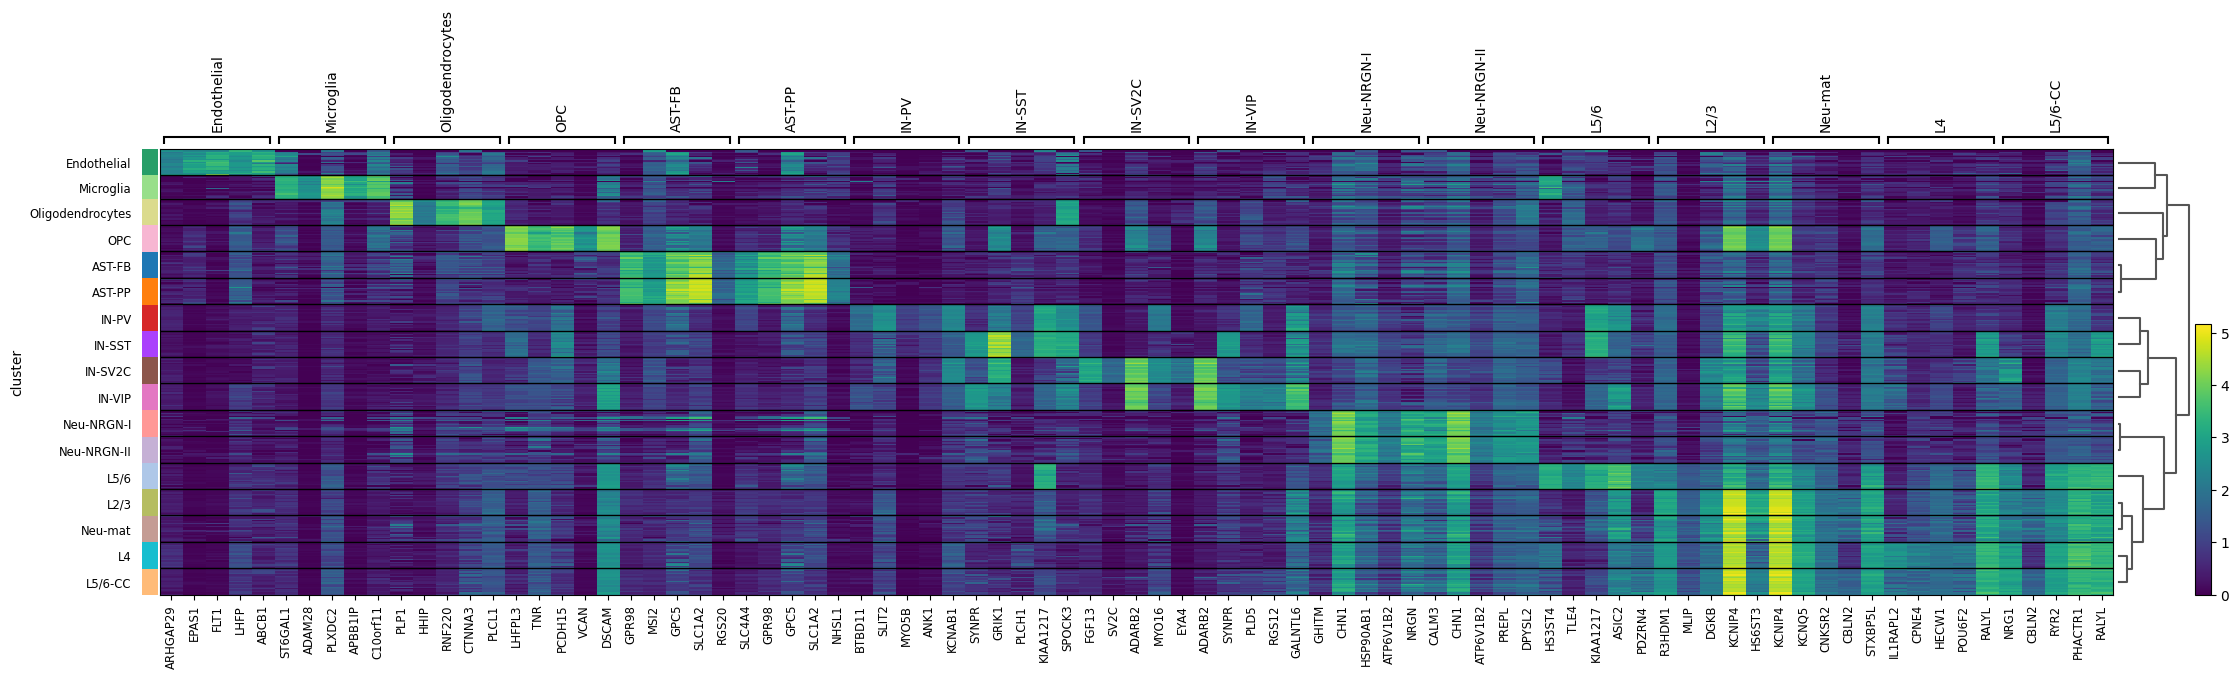

In [22]:
sc.pl.rank_genes_groups_heatmap(adata_pb, n_genes=5, key="t-test", groupby="cluster", show_gene_labels=True)

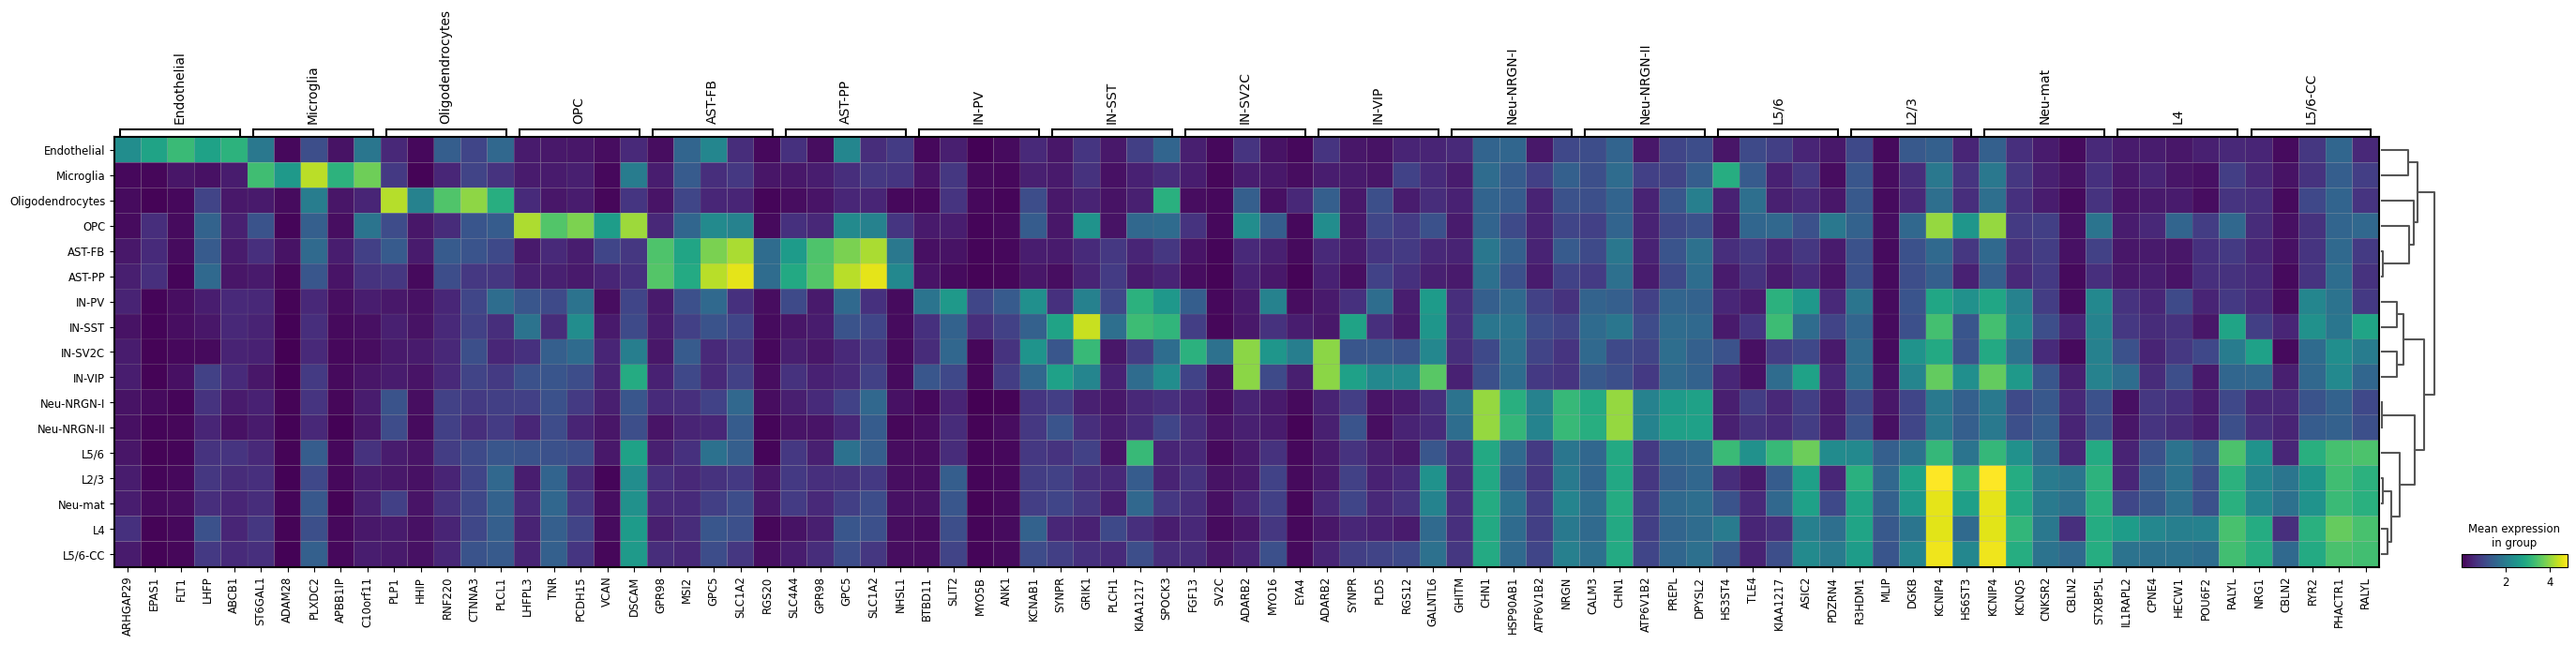

In [23]:
sc.pl.rank_genes_groups_matrixplot(adata_pb, n_genes=5, key="t-test", groupby="cluster")

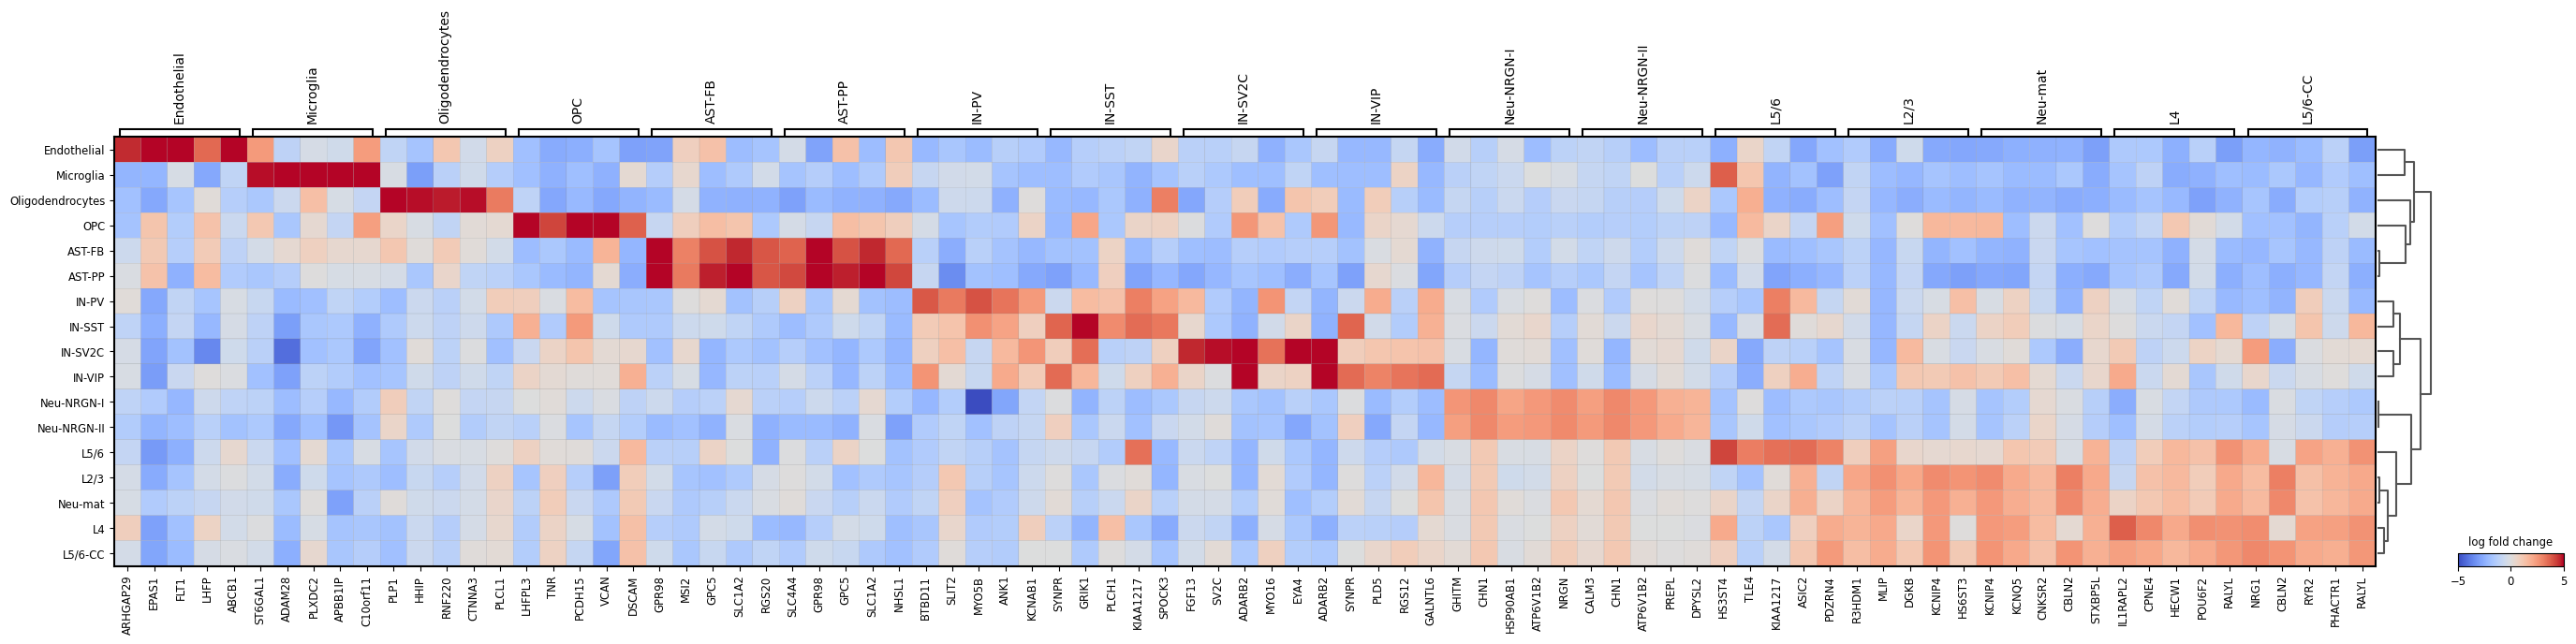

In [24]:
sc.pl.rank_genes_groups_matrixplot(adata_pb, n_genes=5, key="t-test", groupby="cluster", vcenter=0, vmax=5, vmin=-5, values_to_plot='logfoldchanges', cmap='coolwarm')

## Wilcoxon

c:\projects\spatialMPFC\venv\Lib\site-packages\scanpy\plotting\_tools\__init__.py:432: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  ax.set_ylim(ymin, ymax)


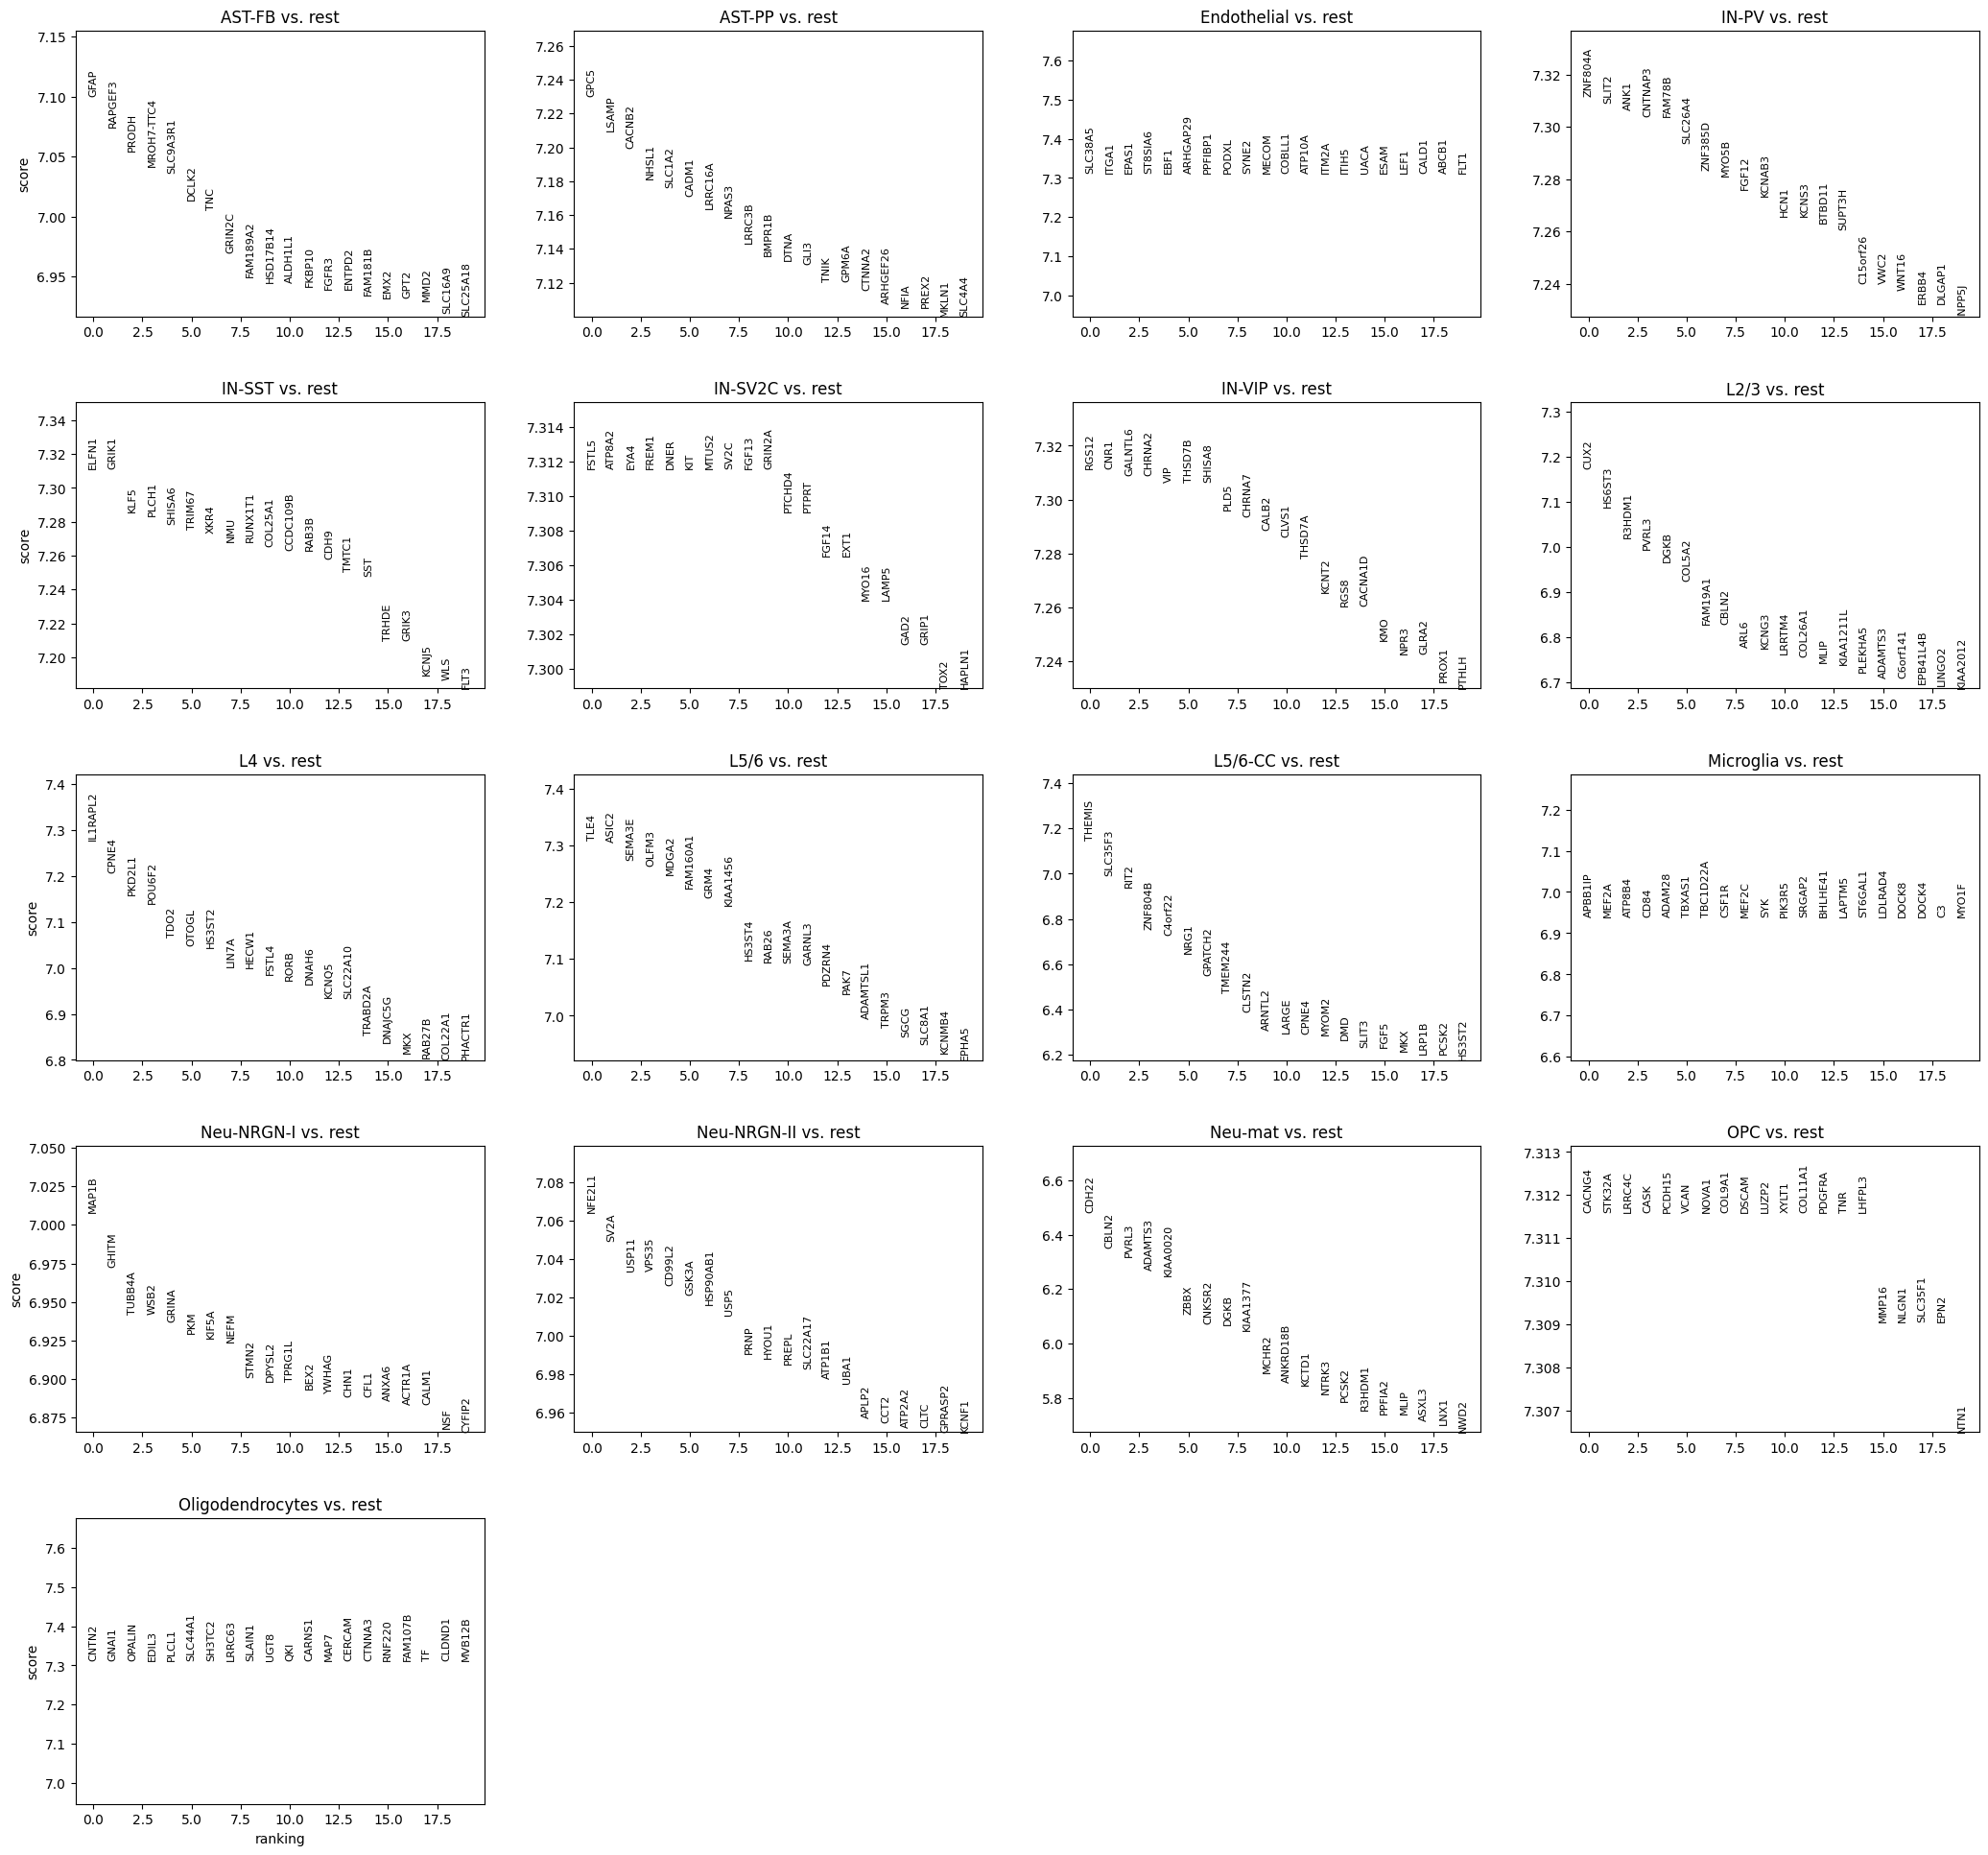

In [25]:
sc.tl.rank_genes_groups(adata_pb, 'cluster', method='wilcoxon', reference='rest', key_added="wilcoxon", pts=True)
sc.pl.rank_genes_groups(adata_pb, n_genes=20, sharey=False, key="wilcoxon")

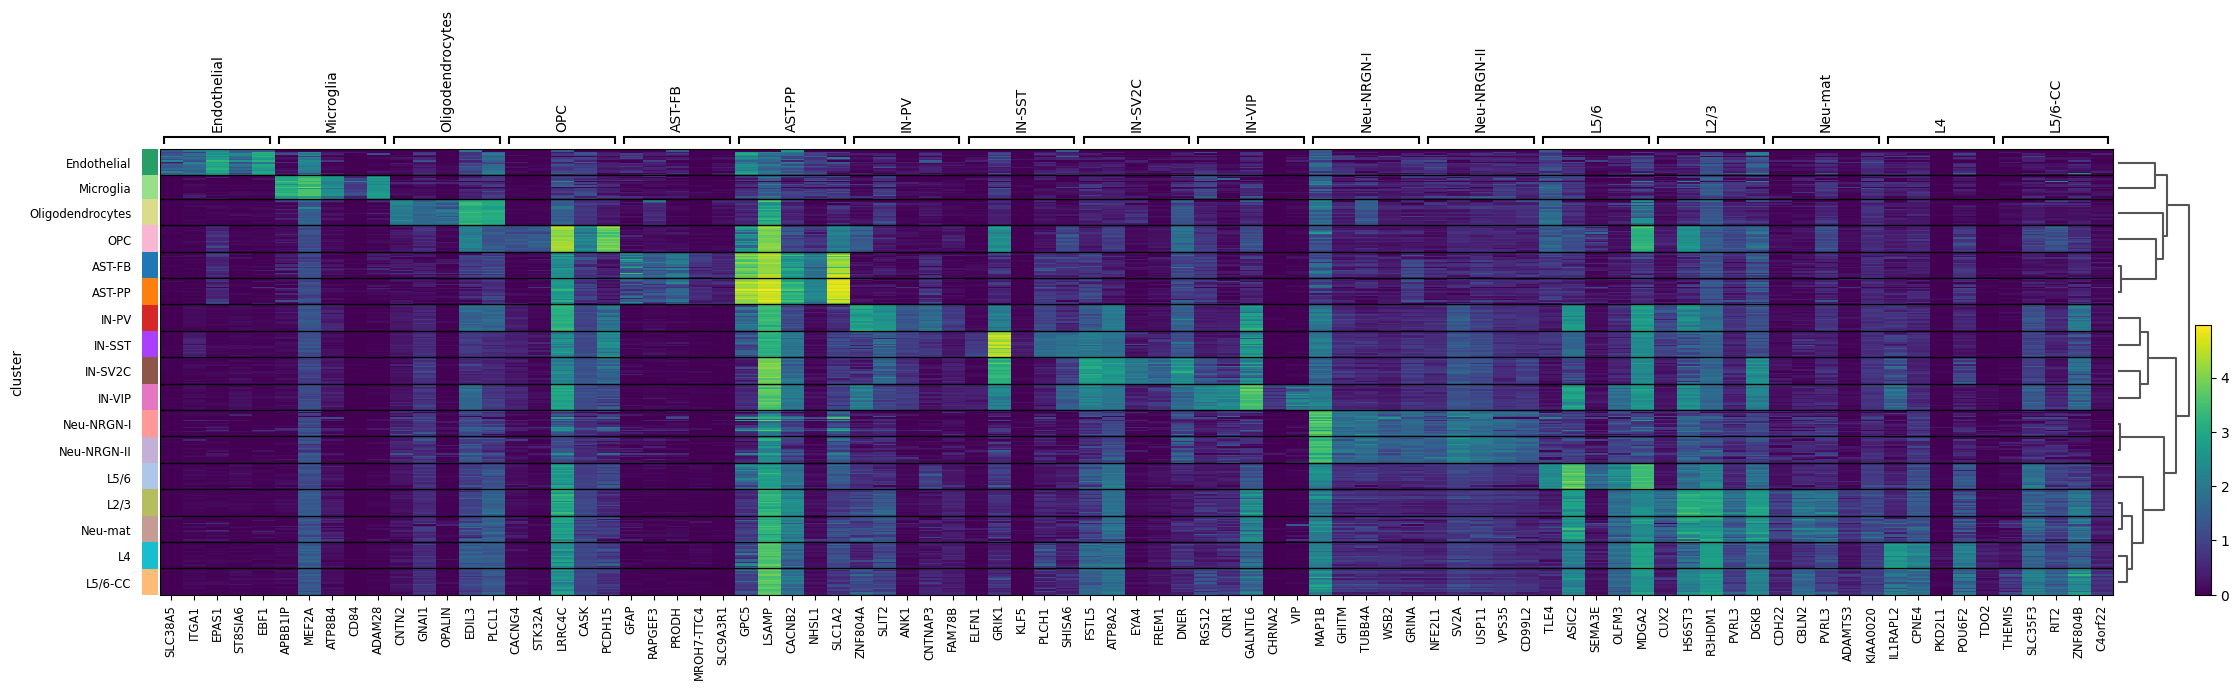

In [26]:
sc.pl.rank_genes_groups_heatmap(adata_pb, n_genes=5, key="wilcoxon", groupby="cluster", show_gene_labels=True)

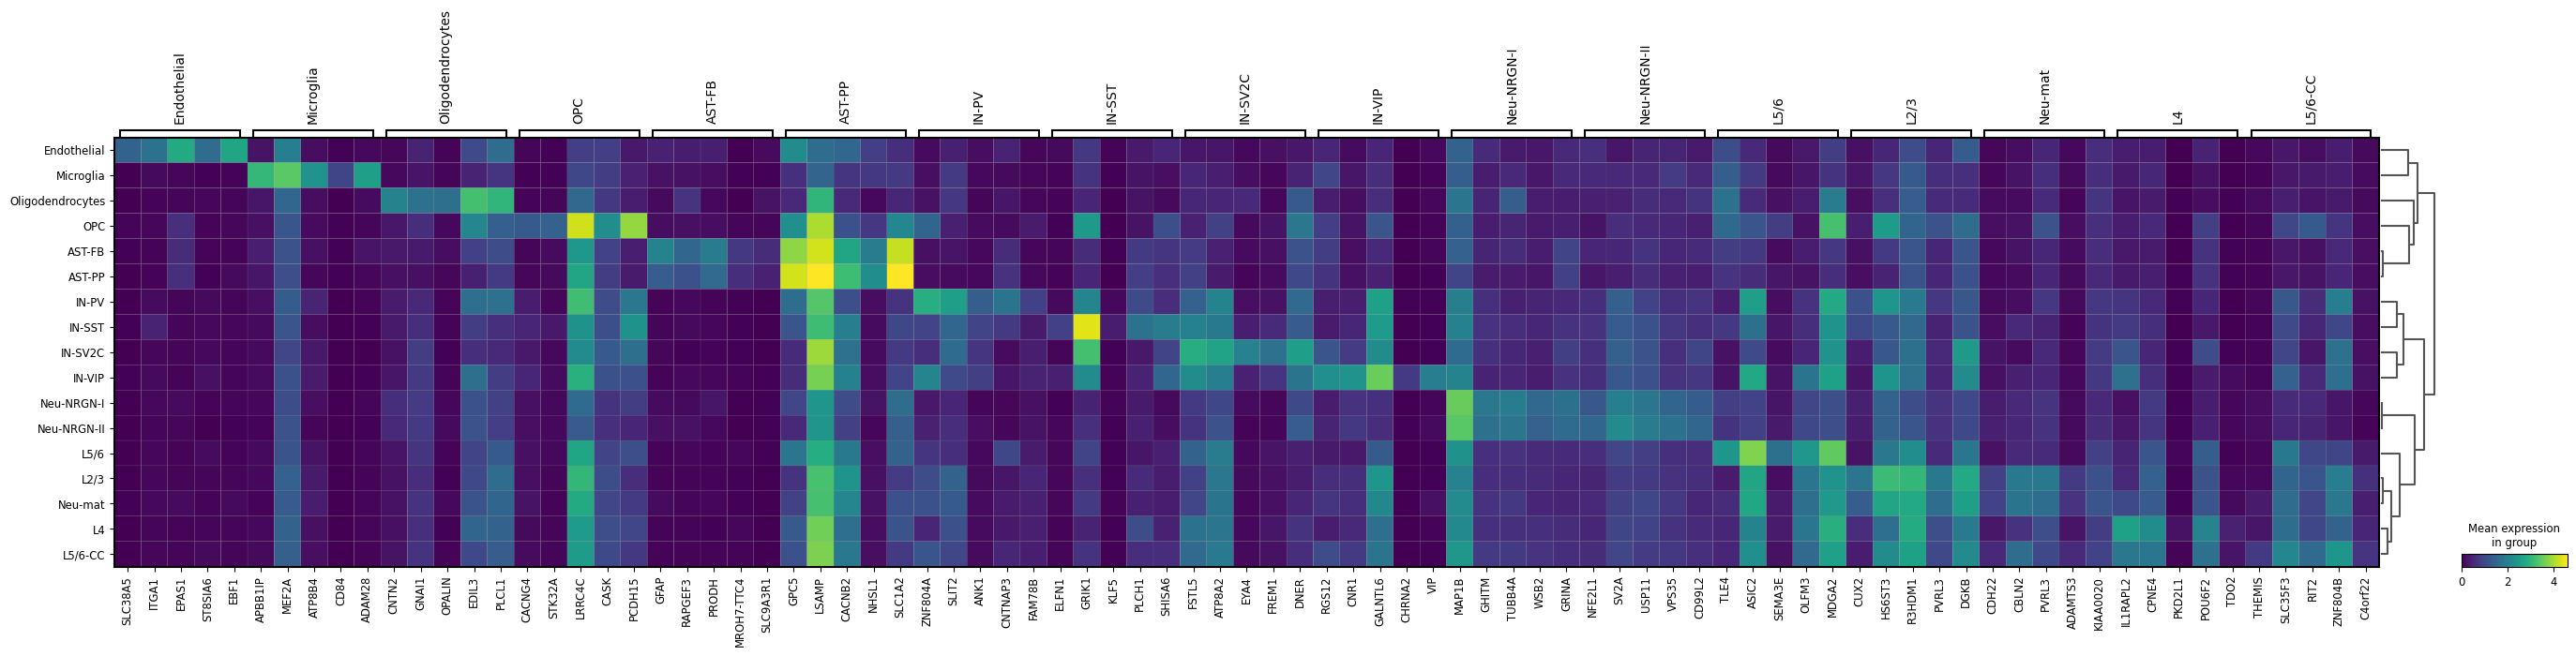

In [27]:
sc.pl.rank_genes_groups_matrixplot(adata_pb, n_genes=5, key="wilcoxon", groupby="cluster")

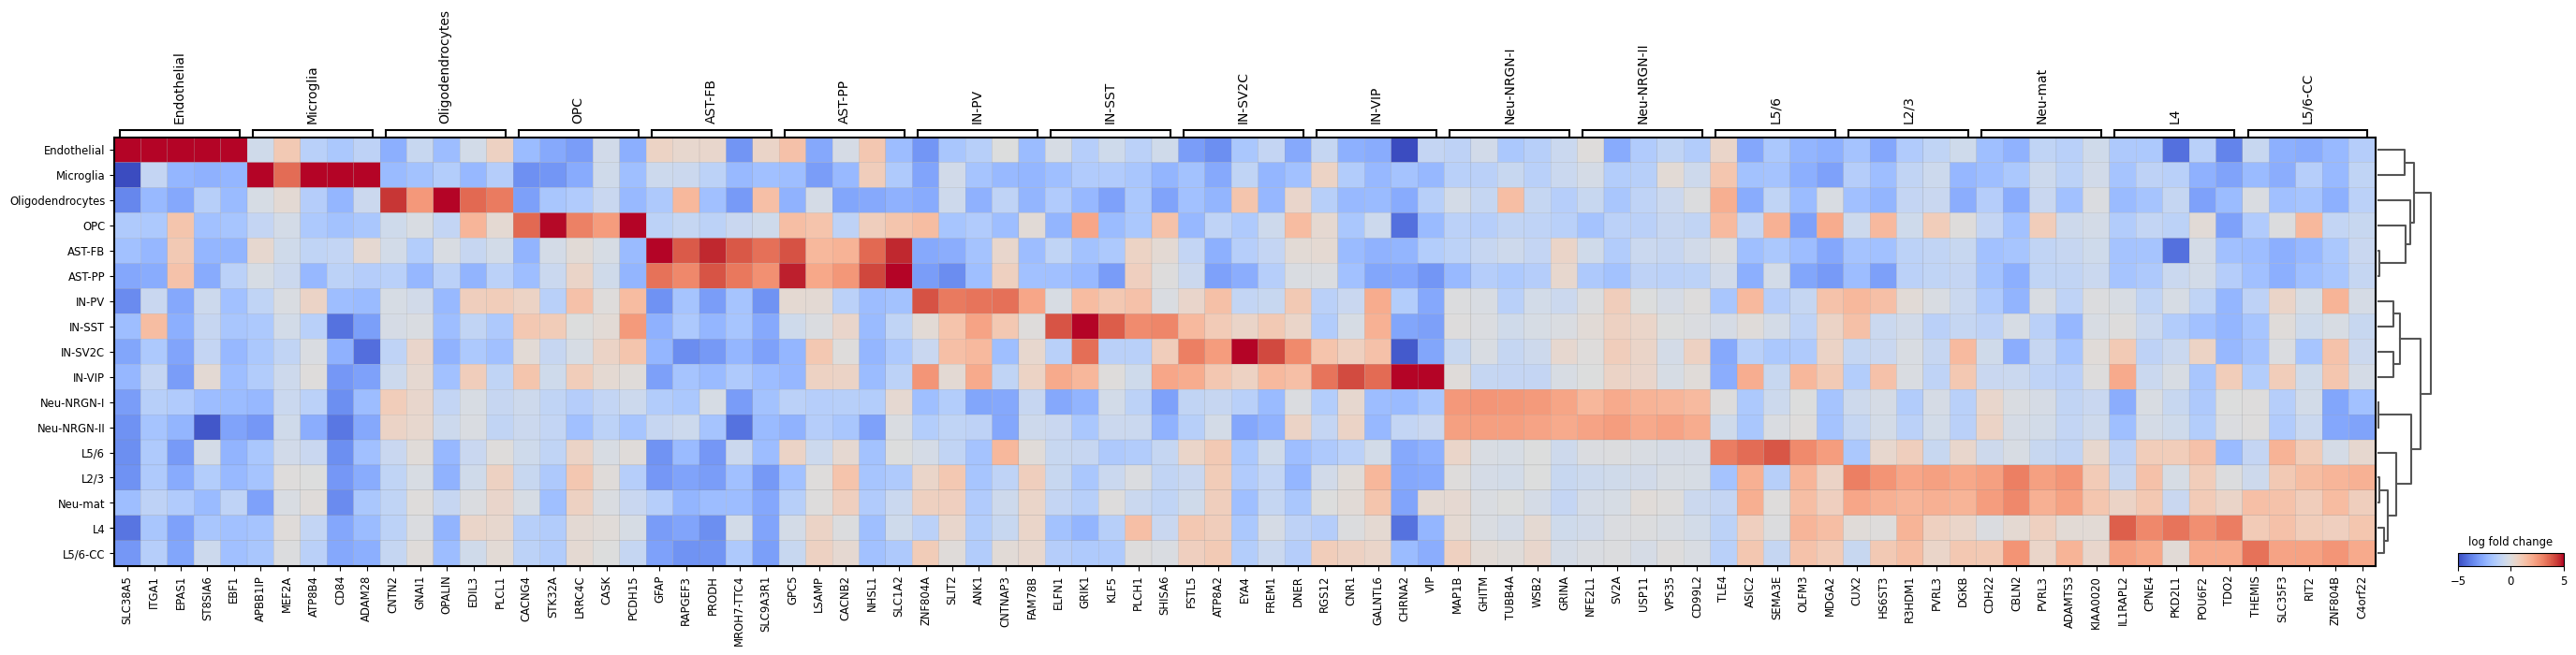

In [28]:
sc.pl.rank_genes_groups_matrixplot(adata_pb, n_genes=5, key="wilcoxon", groupby="cluster", vcenter=0, vmax=5, vmin=-5, values_to_plot='logfoldchanges', cmap='coolwarm')

## Logreg

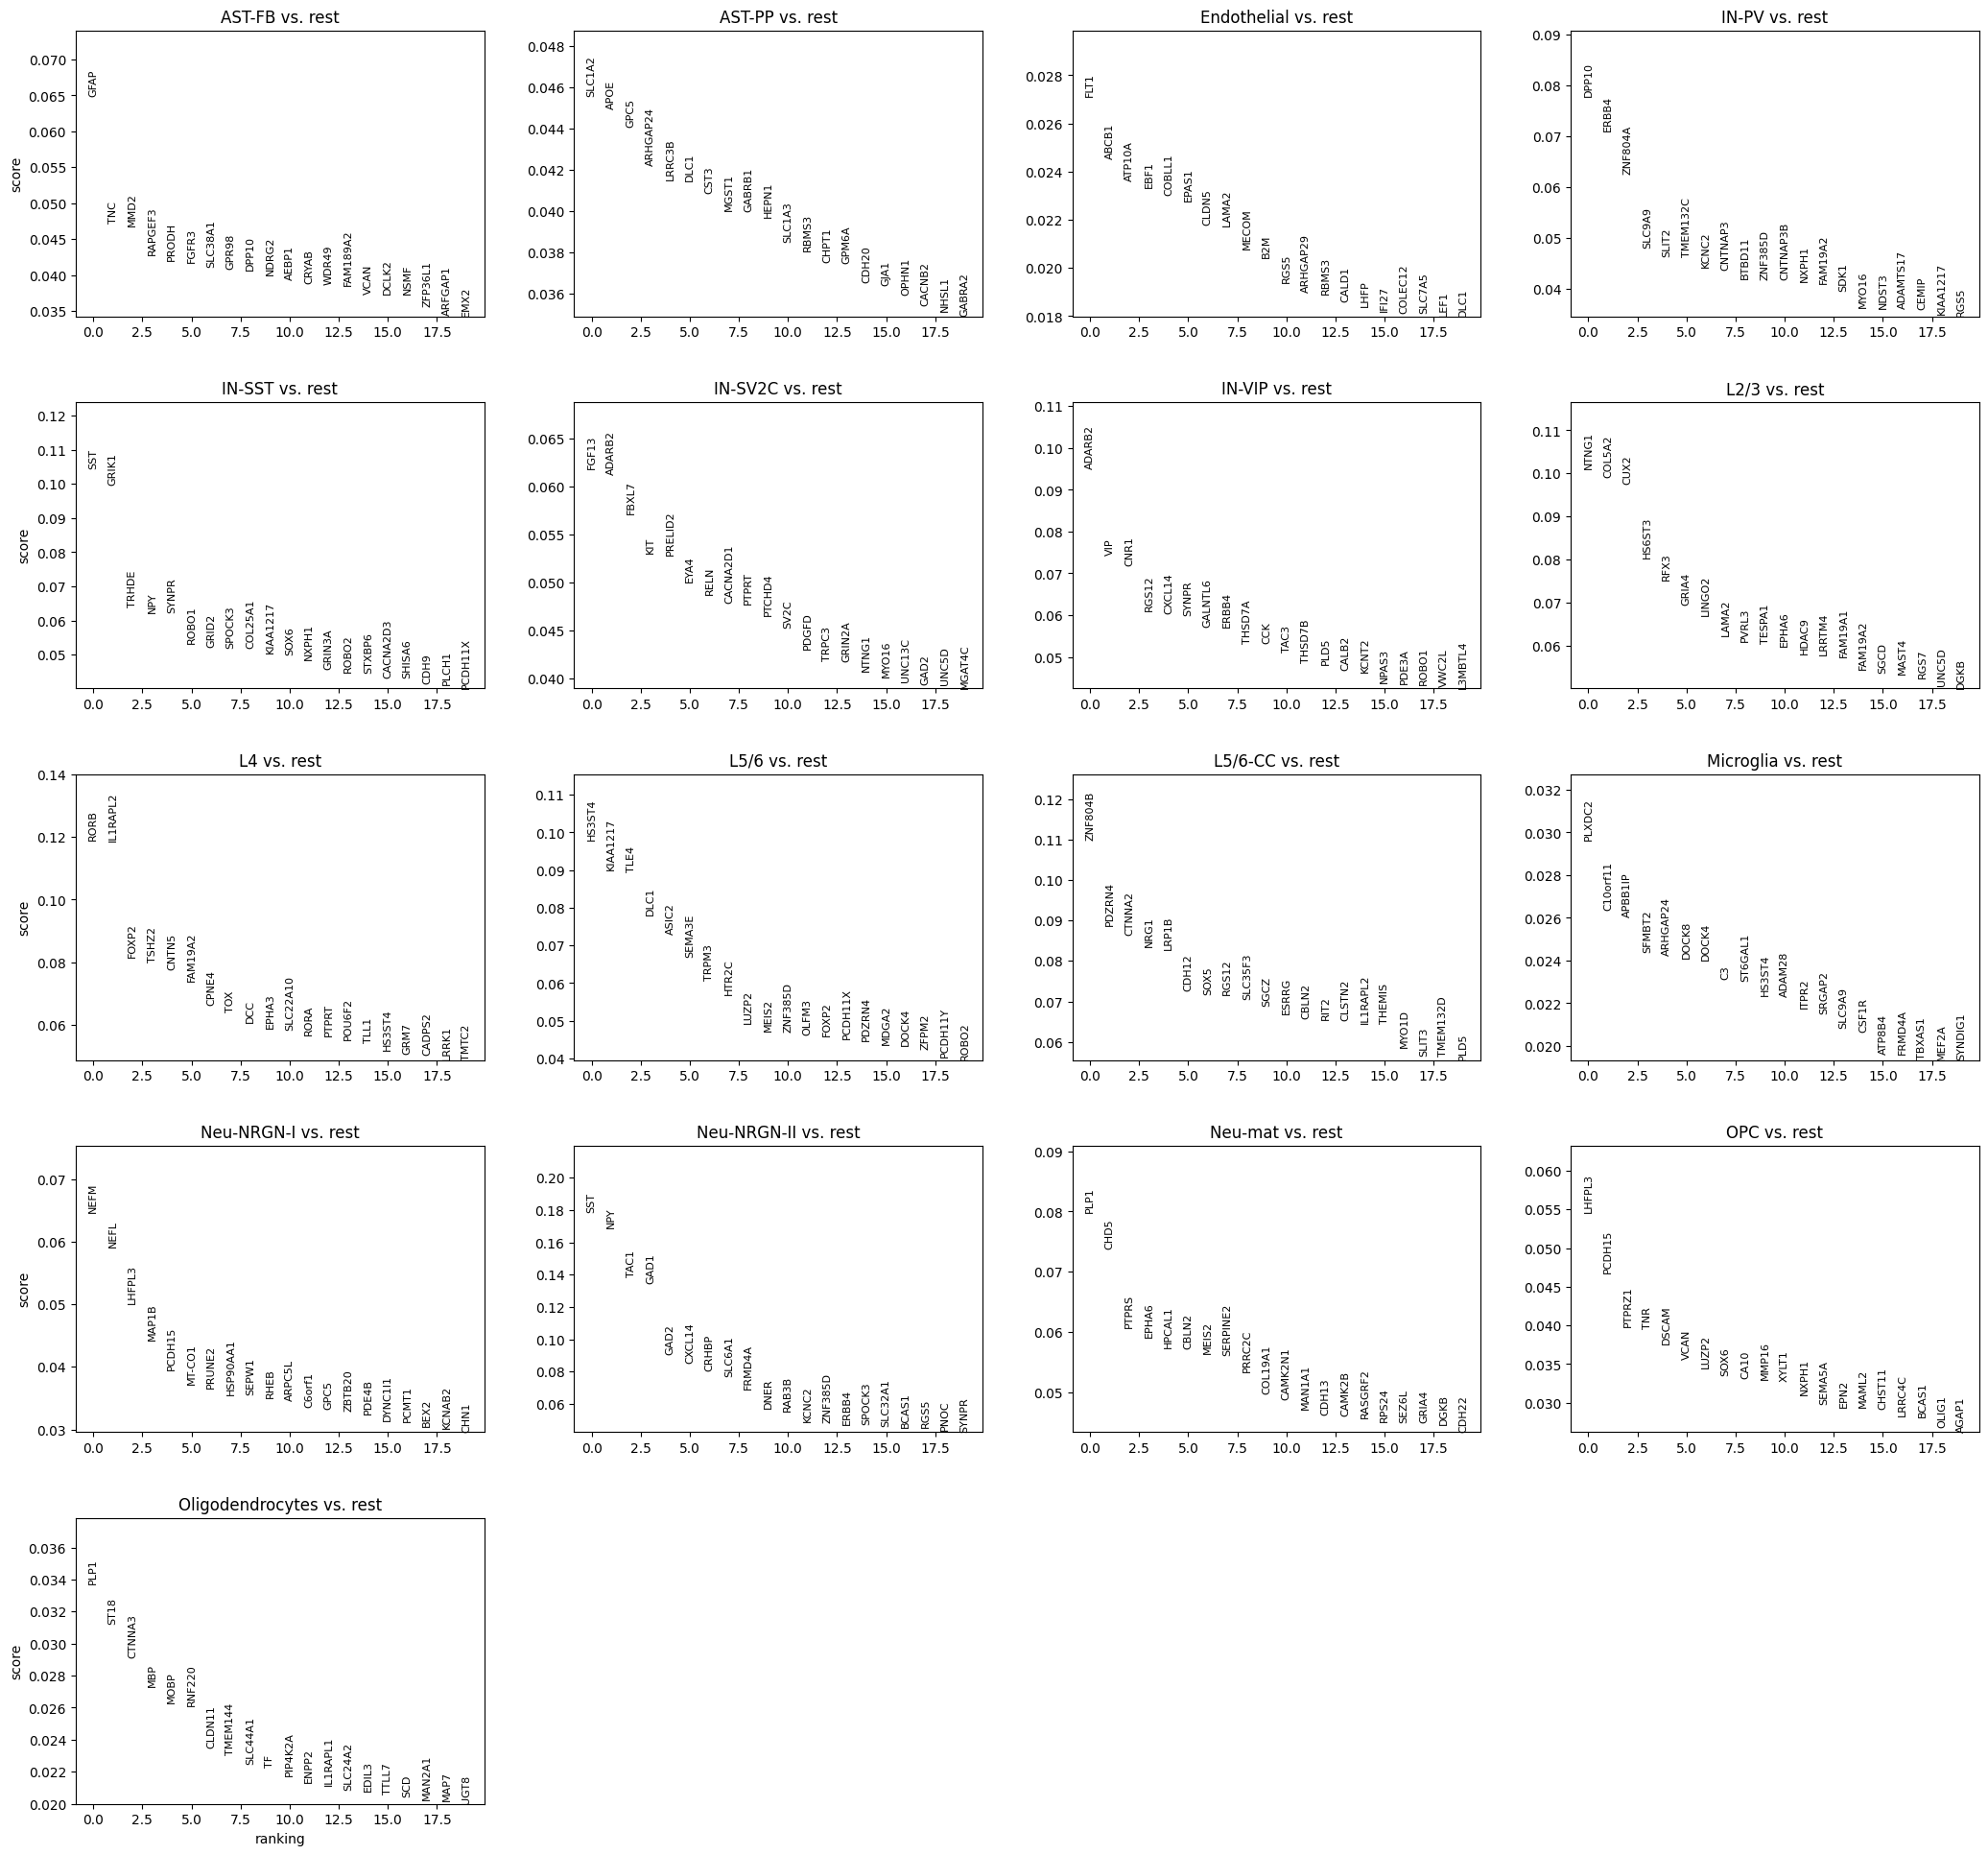

In [29]:
sc.tl.rank_genes_groups(adata_pb, 'cluster', method='logreg', reference='rest', key_added="logreg", pts=True)
sc.pl.rank_genes_groups(adata_pb, n_genes=20, sharey=False, key="logreg")

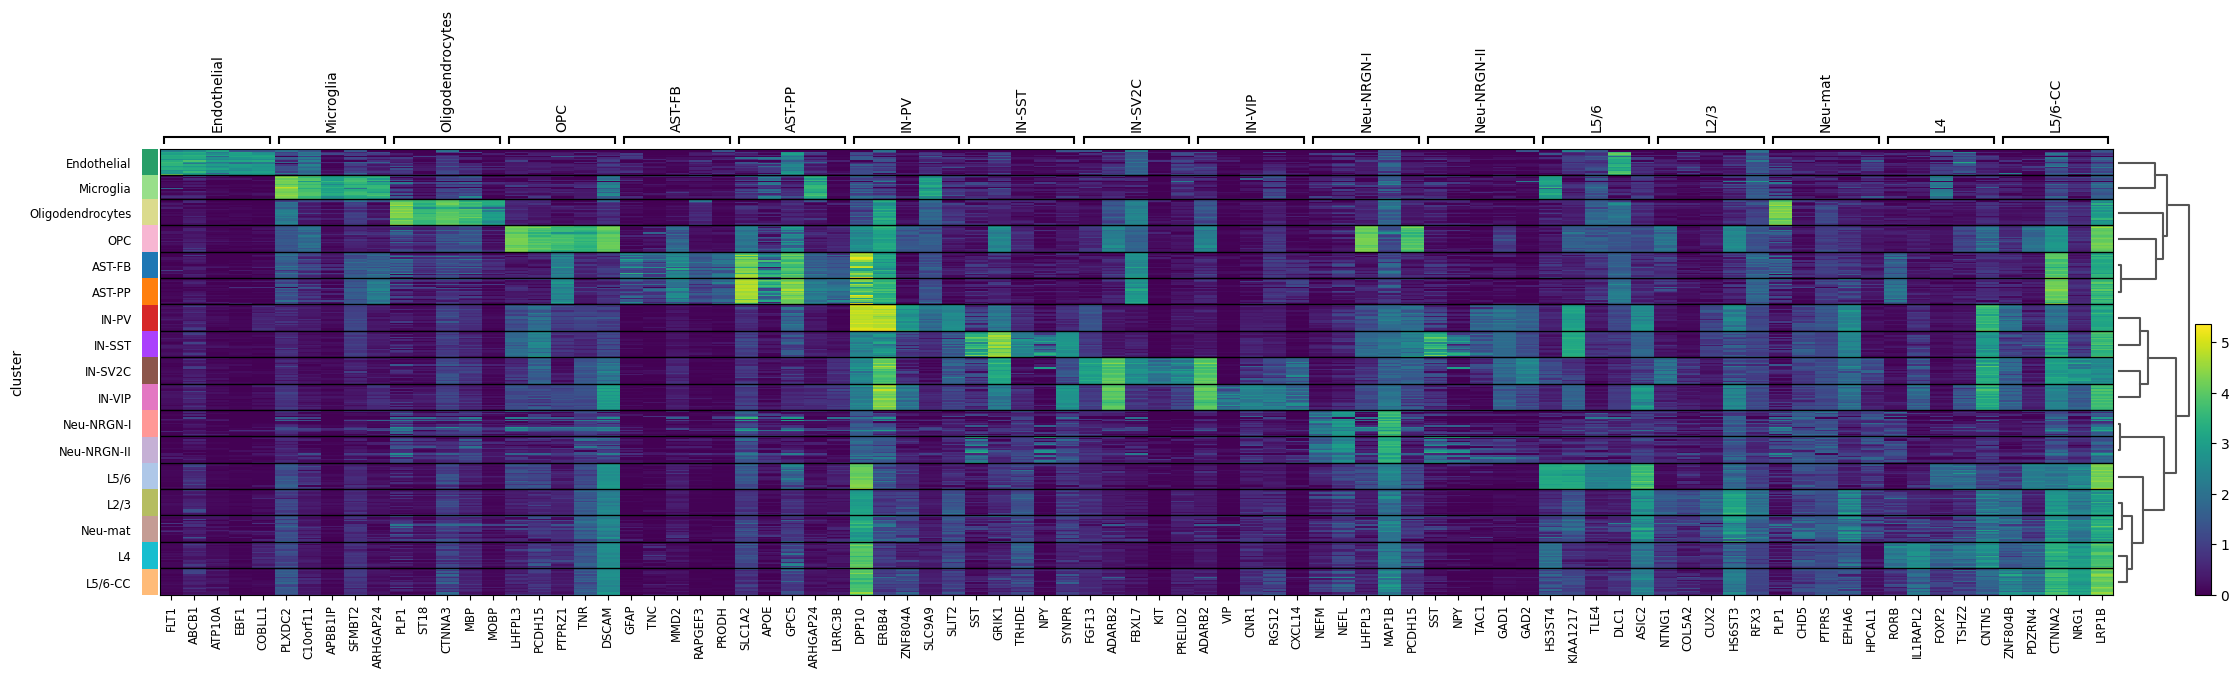

In [30]:
sc.pl.rank_genes_groups_heatmap(adata_pb, n_genes=5, key="logreg", groupby="cluster", show_gene_labels=True)

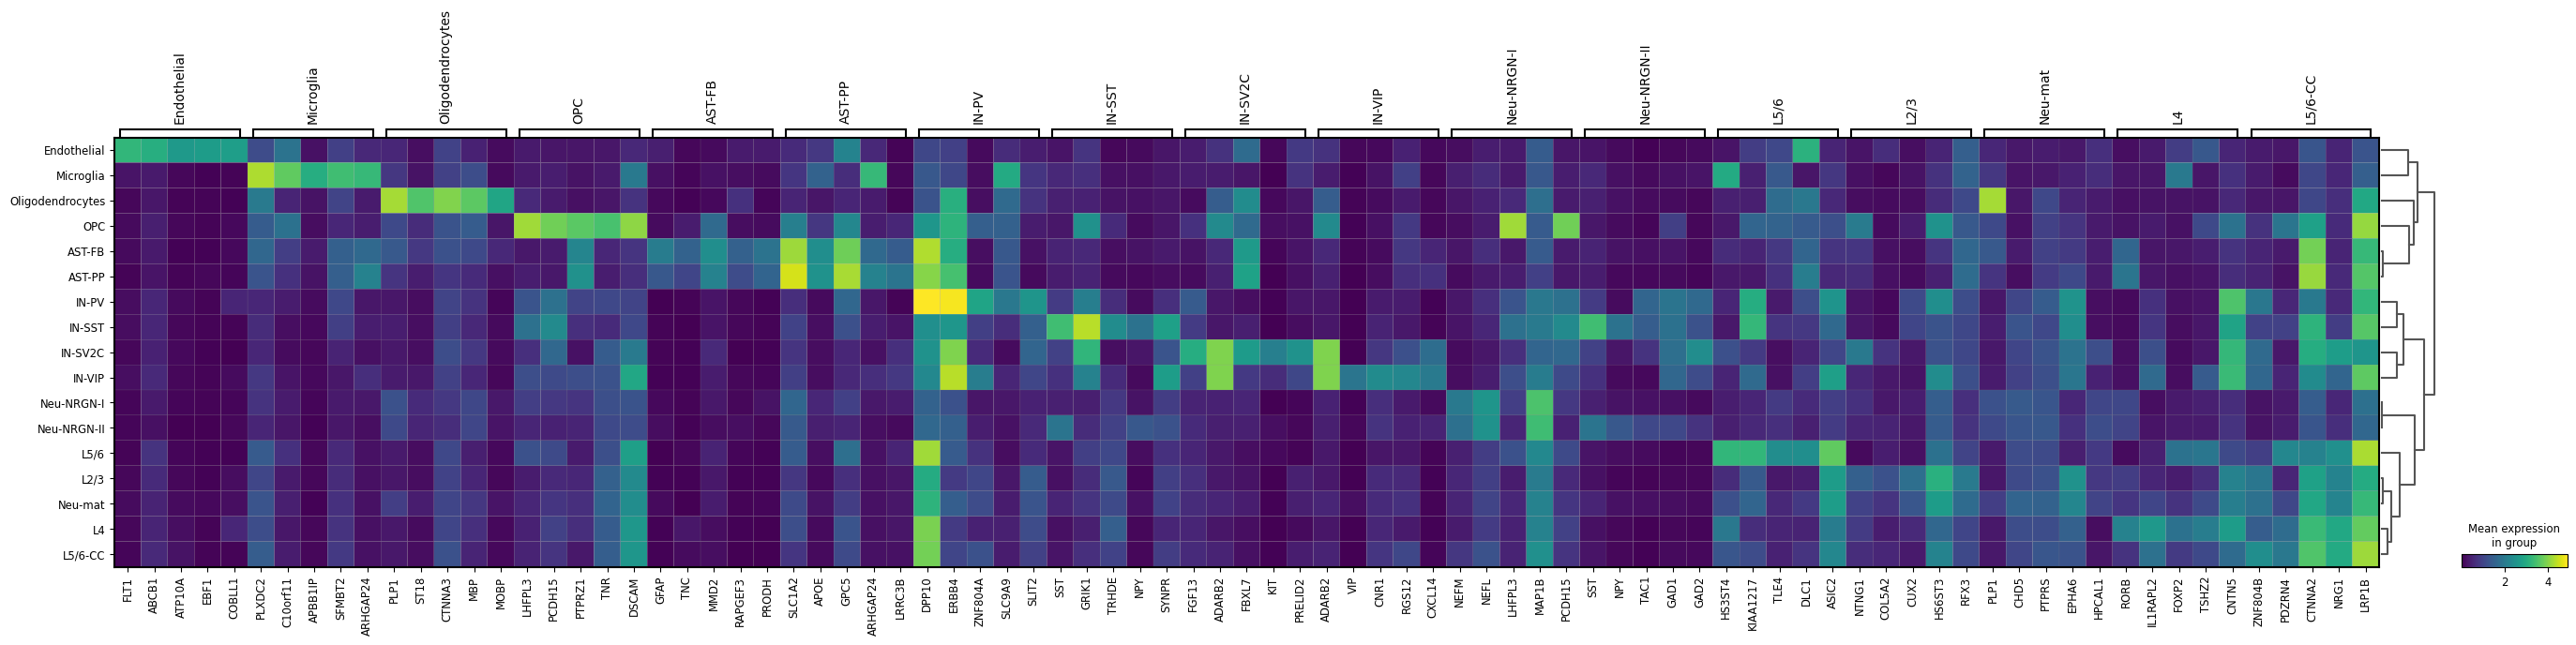

In [31]:
sc.pl.rank_genes_groups_matrixplot(adata_pb, n_genes=5, key="logreg", groupby="cluster")

### Save results

In [32]:
adata_pb.write_h5ad("results/pb_adata_diffexpr.h5ad")